# Comparison of 4 methods

## M 31

In [1]:
# M31
from wfiskymatch.scripts import get2MASSfiles
object = 'M31'
size = 2.0
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
get2MASSfiles(object,size=size,outdir=outdir)

.......................................................................................................................................................................
Imported:  167  files
.......................................................................................................................................................................
Files archived into  /Users/dfadda/Roman/BgrMatch/Comparison/M31.tar


In [33]:
# reproject to healpix
from wfiskymatch.scripts import tarfile2healpix
object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
tarfile2healpix(object, outdir=outdir)

# compute offsets
from wfiskymatch.tools import pixmatch
from glob import glob as gb
import time
start_time = time.time()
files = sorted(gb('/Users/dfadda/Roman/BgrMatch/Comparison/M31_h5/*.h5'))
offsets = pixmatch(files, outfile='/Users/dfadda/Roman/BgrMatch/Comparison/M31_offsets')
end_time = time.time()
print('pixmatch used ', end_time-start_time,' s')

Files will be in  /Users/dfadda/Roman/BgrMatch/Comparison/M31_h5
There is a total of 1220 overlaps
pixmatch used  2.4610109329223633  s


In [2]:
# mosaicking 
from wfiskymatch.scripts import makeMosaic

object = 'M31'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison'
# astropy
makeMosaic(object, outdir)
# pixmatch
makeMosaic(object, outdir, offsetfile=True)

In [152]:
# Skymatch
from wfiskymatch.scripts import runSkymatch

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
runSkymatch(object, outdir,outfile=outdir+object+'_skymatch_offsets')

In [1]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from wfiskymatch.skymatch import reprojectAll
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from glob import glob as gb

path = '/Users/dfadda/Roman/BgrMatch/Comparison/M31/'
input_data = sorted(gb('/Users/dfadda/Roman/BgrMatch/Comparison/M31/*.fits'))

wcs_out, shape_out = find_optimal_celestial_wcs(input_data)
imacube0, footprint0 = reprojectAll(input_data,wcs_out, shape_out=shape_out,
                                reproject_function=reproject_interp)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 


In [3]:
from wfiskymatch.tools import maskSources
from astropy.io import fits
import matplotlib.pyplot as plt

path = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
with fits.open(path+object+'_wfiskymatch.fits') as f:
    data = f[0].data

wfimask = maskSources(data, fwhm=2.0, areathreshold=100, eccthreshold=0.8,nsigma=2)

In [15]:
import h5py
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + 'M31_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

nz,nx,ny = np.shape(imacube0)
print(nz,nx,ny)

sk_med = np.full((167, 167), np.nan)
sk_disp = np.full((167,167), np.nan)
sk_differences = []
for i in range(167):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    imask = wfimask[imin:imax,jmin:jmax]
    for j in range(i+1,167):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))# & (imask == 0))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] - offsets[i] + offsets[j]
            sk_med[i,j]=np.nanmedian(dimage[idx])
            sk_disp[i,j]=np.nanstd(dimage[idx])
            sk_differences.append(dimage[idx])

167 8306 7944
.......................................................................................................................................................................

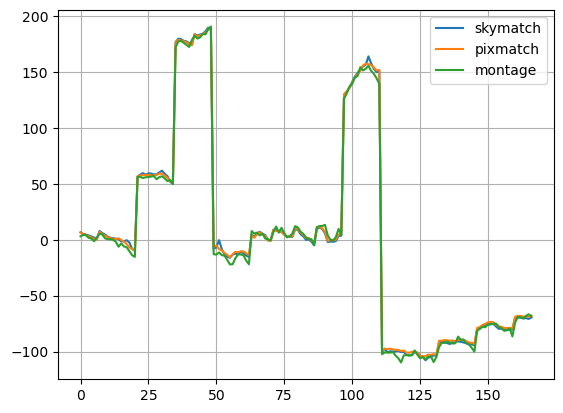

In [14]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
with h5py.File(outdir + object+'_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

index = []
for o, f in zip(offsets, files):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(offsets[idx] - np.median(offsets), label='skymatch')

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

index = []
for o, f in zip(offsets2, files2):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(-offsets2[idx], label='pixmatch' )

from astropy.table import Table
from astropy.io import ascii

data = ascii.read(outdir+object+"_montage/images.tbl")
index = []
for f in data['fname']:
    f0 = f.split('.')[0]
    a,b,fi = f0.split('_')
    index.append(int(fi))

data = ascii.read(outdir+object+"_montage/corrections.tbl")
index1 = data['id']
offsets3 = data['c']
idx = np.argsort(np.array(index1))
o3 = offsets3[idx]
idx = np.argsort(index)
plt.plot(o3[idx] - np.nanmedian(o3) , label='montage')
plt.legend()
plt.grid()
plt.show()

In [16]:
nz,nx,ny = np.shape(imacube0)
print(nz,nx,ny)

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + 'M31_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

pm_med = np.full((167, 167), np.nan)
pm_disp = np.full((167,167), np.nan)
pm_differences = []
for i in range(167):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    imask = wfimask[imin:imax,jmin:jmax]
    for j in range(i+1,167):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))# & (imask == 0))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] + offsets2[i] - offsets2[j]
            pm_med[i,j]=np.nanmedian(dimage[idx])
            pm_disp[i,j]=np.nanstd(dimage[idx])
            pm_differences.append(dimage[idx])

167 8306 7944
.......................................................................................................................................................................

In [1]:
# Montage
from wfiskymatch.scripts import runMontage

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
runMontage(object, outdir)

[struct stat="OK", module="mImgtbl", count=167, nfile=167, nhdu=167, badfits=0, badwcs=0]
[struct stat="OK", module="mMakeHdr", msg="Cube columns exist but are either blank or inconsistent. Outputting 2D only.", count=167, ncube=0, naxis1=7946, naxis2=8304, clon=10.716730, clat=41.259552, lonsize=2.207222, latsize=2.306667, posang=359.969990, lon1=12.158244, lat1=40.096860, lon2=9.273612, lat2=40.097996, lon3=9.223385, lat3=42.403616, lon4=12.211682, lat4=42.402440]
[struct stat="OK", module="mProjExec", count=167, failed=0, nooverlap=0]
[struct stat="OK", module="mImgtbl", count=167, nfile=167, nhdu=167, badfits=0, badwcs=0]
[struct stat="OK", module="mAdd", time=3]
[struct stat="OK", module="mOverlaps", count=479]
[struct stat="OK", module="mDiffExec", count=479, failed=1]
[struct stat="OK", module="mFitExec", count=479, failed=0, warning=0, missing=1]
[struct stat="OK", module="mBgModel"]
[struct stat="OK", module="mBgExec", count=167, nocorrection=0, failed=0]
[struct stat="OK", mo

In [7]:
# Mask sources of montage
from wfiskymatch.tools import maskSources
from astropy.io import fits
import matplotlib.pyplot as plt

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
with fits.open(outdir+object+'_montage.fits') as f:
    data = f[0].data

mask = maskSources(data, fwhm=2.0, areathreshold=100, eccthreshold=0.8,nsigma=2)

0 7946 0 8304


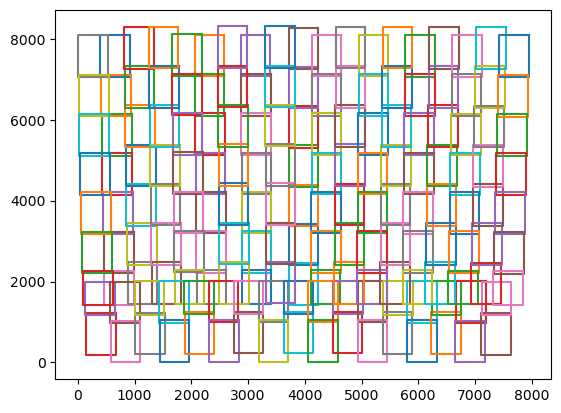

In [8]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

image = np.full((167,8304, 7946), np.nan)

x0, y0 = 3973.5, 4152.5 

path = '/Users/dfadda/Roman/BgrMatch/Comparison/M31_montage/corrdir/'
fig,ax = plt.subplots()
xmax, ymax = 0,0
xmin, ymin = 10000,10000
for i in range(167):
    file = path + 'hdu0_M31_'+str(i)+'.fits'
    with fits.open(file) as f:
        h = f[0].header
        x, y = int(h['CRPIX1']+x0-1), int(h['CRPIX2']+y0-1)
        nx, ny = h['NAXIS1'], h['NAXIS2']        
        plt.plot([x,x-nx,x-nx,x,x],[y,y,y-ny,y-ny,y])
        xmin = x-nx if (x-nx) < xmin else xmin
        ymin = y-ny if (y-ny) < ymin else ymin
        xmax = x if x > xmax else xmax
        ymax = y if y > ymax else ymax
        ima = f[0].data
        image[i,y-ny:y,x-nx:x] = ima

print(xmin,xmax,ymin,ymax)

In [17]:
# Compute statistics of differences

nz,nx,ny = np.shape(image)
print(nz,nx,ny)
print(np.shape(image[0,:,:]))

med = np.full((167, 167), np.nan)
disp = np.full((167,167), np.nan)
differences = []
for i in range(167):
    print('.',end='')
    idx = np.where(np.isfinite(image[i,:,:]))
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = image[:,imin:imax,jmin:jmax]
    imask = mask[imin:imax,jmin:jmax]
    for j in range(i+1,167):
        idx = np.where(np.isfinite(iimages[i]) & np.isfinite(iimages[j]))# & (imask == 0))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:]
            med[i,j]=np.nanmedian(dimage[idx])
            disp[i,j]=np.nanstd(dimage[idx])
            differences.append(dimage[idx])

167 8304 7946
(8304, 7946)
.......................................................................................................................................................................

montage  446
skymatch  468
pixmatch  478


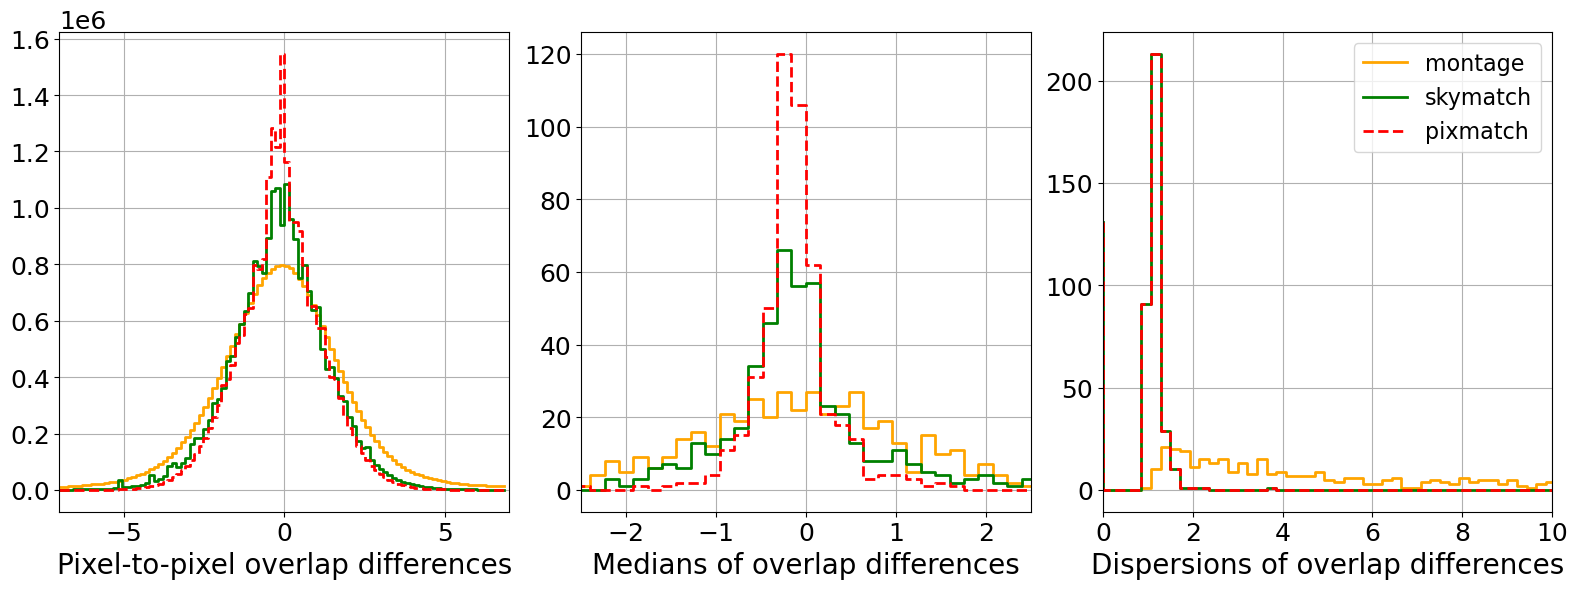

In [10]:
import matplotlib as mpl

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 3, figsize=(16,6))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
idx = np.abs(diff) < 10
y, x = np.histogram(diff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, label='montage')
skdiff = np.concatenate(sk_differences)
idx = np.abs(skdiff) < 10
y, x = np.histogram(skdiff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, label='skymatch')
pmdiff = np.concatenate(pm_differences)
idx = np.abs(pmdiff) < 10
y, x = np.histogram(pmdiff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, '--', label='pixmatch')
ax[0].set_xlim(-7,7)
ax[0].set_xlabel('Pixel-to-pixel overlap differences')

# Histogram of medians
mmed = np.concatenate(med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('montage ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y, label='montage')
mmed = np.concatenate(sk_med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('skymatch ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y, label='skymatch')
mmed = np.concatenate(pm_med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('pixmatch ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y,'--', label='pixmatch')
ax[1].set_xlim(-2.5,2.5)
ax[1].set_xlabel('Medians of overlap differences')

# Histogram of dispersions
dev = np.concatenate(disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y, label='montage')
dev = np.concatenate(sk_disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y, label='skymatch')
dev = np.concatenate(pm_disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y,'--', label='pixmatch')
ax[2].set_xlabel('Dispersions of overlap differences')
ax[2].set_xlim(0,10)

fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
fig.savefig(outdir+object+'_histos.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

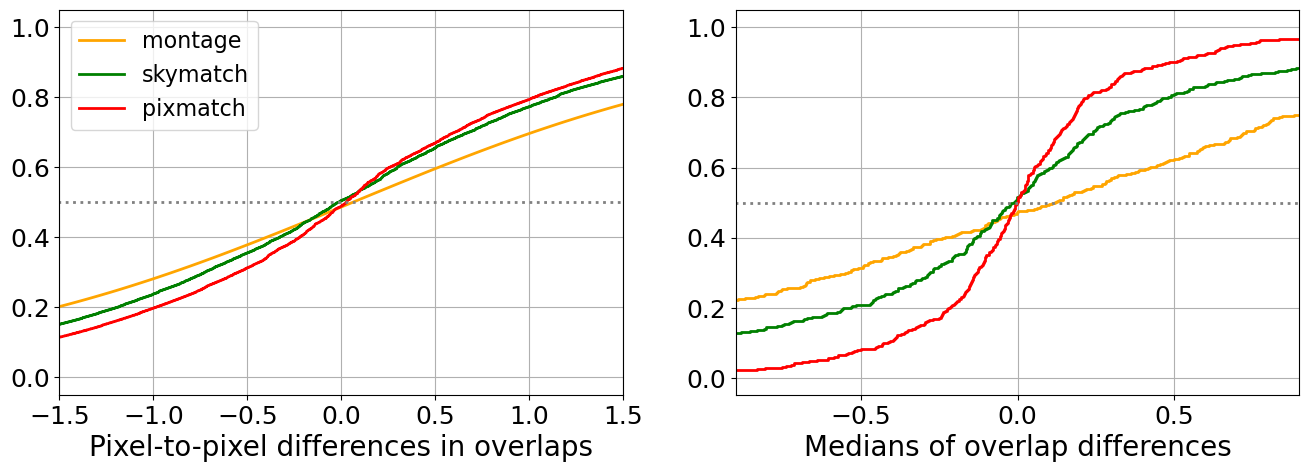

In [11]:
# Cumulative histograms
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib as mpl

object = 'M31'

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
ediff = ECDF(diff)
ax[0].step(ediff.x, ediff.y,label='montage')

skdiff = np.concatenate(sk_differences)
eskdiff = ECDF(skdiff)
ax[0].step(eskdiff.x, eskdiff.y,label='skymatch')

pmdiff = np.concatenate(pm_differences)
epmdiff = ECDF(pmdiff)
ax[0].step(epmdiff.x, epmdiff.y,label='pixmatch')

ax[0].legend(fontsize=16, loc='upper left')
ax[0].set_xlim(-1.5,1.5)
ax[0].grid()
ax[0].set_xlabel('Pixel-to-pixel differences in overlaps')
ax[0].axhline(0.5,-1.5,1.5,ls=':',color='grey')


# Histogram of pixel-to-pixel differences
mmed = np.concatenate(med)
idx = np.isfinite(mmed)
emed = ECDF(mmed[idx])
ax[1].step(emed.x, emed.y,label='montage')

mmed = np.concatenate(sk_med)
idx = np.isfinite(mmed)
eskmed = ECDF(mmed[idx])
ax[1].step(eskmed.x, eskmed.y,label='skymatch')

mmed = np.concatenate(pm_med)
idx = np.isfinite(mmed)
epmmed = ECDF(mmed[idx])
ax[1].step(epmmed.x, epmmed.y,label='pixmatch')
ax[1].axhline(0.5,-1.5,1.5,ls=':',color='grey')
ax[1].set_xlim(-0.9,0.9)
ax[1].grid()
ax[1].set_xlabel('Medians of overlap differences')

fig.savefig(outdir+object+'_cum.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

In [14]:
# Statistics of differences

mmed = np.concatenate(med)
print('Montage ', np.nanstd(mmed))
mmed = np.concatenate(sk_med)
print('Skymatch ', np.nanstd(mmed))
mmed = np.concatenate(pm_med)
print('PixMatch ', np.nanstd(mmed))

Montage  3.979302546176774
Skymatch  1.399962318279197
PixMatch  0.440440373376967


In [18]:
mmed = np.concatenate(med)
print('Montage ', np.nanstd(mmed))
mmed = np.concatenate(sk_med)
print('Skymatch ', np.nanstd(mmed))
mmed = np.concatenate(pm_med)
print('PixMatch ', np.nanstd(mmed))

Montage  3.975378127394697
Skymatch  1.400306296924983
PixMatch  0.4405091621257413


In [14]:
print((1.40/0.44-1)*100)
print((3.98/0.44-1)*100)

218.18181818181816
804.5454545454545


## NGC 598

In [1]:
from wfiskymatch.scripts import get2MASSfiles
object = 'NGC598'
size = 2.0
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
get2MASSfiles(object,size=size,outdir=outdir)


Imported:  157  files


In [1]:
# reproject to healpix
from wfiskymatch.scripts import tarfile2healpix
import os
object = 'NGC598'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
tarfile2healpix(object, outdir=outdir)

# compute offsets
from wfiskymatch.tools import pixmatch
from glob import glob as gb
h5outdir = os.path.join(outdir,object+'_h5')
files = sorted(gb(os.path.join(h5outdir,'*.h5')))
offsets = pixmatch(files, outfile=outdir+object+'_offsets')

# mosaicking 
from wfiskymatch.scripts import makeMosaic
# astropy
makeMosaic(object, outdir)
# pixmatch
makeMosaic(object, outdir, offsetfile=True)

Files will be in  /Users/dfadda/Roman/BgrMatch/Comparison/NGC598_h5
There is a total of 1144 overlaps


In [1]:
# Skymatch
from wfiskymatch.scripts import runSkymatch
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'NGC598'
runSkymatch(object, outdir,outfile=outdir+object+'_skymatch_offsets')



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
! WARNING: Clipped data falls within 1 histogram bin


In [6]:
# Montage
from wfiskymatch.scripts import runMontage
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'NGC598'
runMontage(object, outdir, clean=False)

[struct stat="OK", module="mImgtbl", count=157, nfile=157, nhdu=157, badfits=0, badwcs=0]
[struct stat="OK", module="mMakeHdr", msg="Cube columns exist but are either blank or inconsistent. Outputting 2D only.", count=157, ncube=0, naxis1=7982, naxis2=8370, clon=23.453588, clat=30.612254, lonsize=2.217222, latsize=2.325000, posang=359.497025, lon1=24.714348, lat1=29.434291, lon2=22.169152, lat2=29.453520, lon3=22.161940, lat3=31.777759, lon4=24.768961, lat4=31.758064]
[struct stat="OK", module="mProjExec", count=157, failed=0, nooverlap=0]
[struct stat="OK", module="mImgtbl", count=157, nfile=157, nhdu=157, badfits=0, badwcs=0]
[struct stat="OK", module="mAdd", time=3]
[struct stat="OK", module="mOverlaps", count=425]
[struct stat="OK", module="mDiffExec", count=425, failed=0]
[struct stat="OK", module="mFitExec", count=425, failed=0, warning=0, missing=0]
[struct stat="OK", module="mBgModel"]
[struct stat="OK", module="mBgExec", count=157, nocorrection=0, failed=0]
[struct stat="OK", 

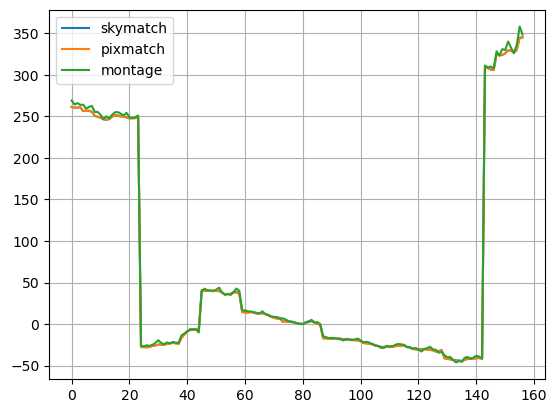

In [1]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'NGC598'
with h5py.File(outdir + object+'_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

index = []
for o, f in zip(offsets, files):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(offsets[idx] - np.median(offsets), label='skymatch')

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

index = []
for o, f in zip(offsets2, files2):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(-offsets2[idx], label='pixmatch' )

from astropy.table import Table
from astropy.io import ascii

data = ascii.read(outdir+object+"_montage/images.tbl")
index = []
for f in data['fname']:
    f0 = f.split('.')[0]
    a,b,fi = f0.split('_')
    index.append(int(fi))

data = ascii.read(outdir+object+"_montage/corrections.tbl")
index1 = data['id']
offsets3 = data['c']
idx = np.argsort(np.array(index1))
o3 = offsets3[idx]
idx = np.argsort(index)
plt.plot(o3[idx] - np.nanmedian(o3) , label='montage')
plt.legend()
plt.grid()
plt.show()


In [1]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from wfiskymatch.skymatch import reprojectAll
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from glob import glob as gb

object = 'NGC598'
path = '/Users/dfadda/Roman/BgrMatch/Comparison/'
input_data = sorted(gb('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'/*.fits'))

wcs_out, shape_out = find_optimal_celestial_wcs(input_data)
imacube0, footprint0 = reprojectAll(input_data,wcs_out, shape_out=shape_out,
                                reproject_function=reproject_interp)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 


In [2]:
import h5py
object = 'NGC598'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object + '_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

nz,nx,ny = np.shape(imacube0)
print(nz,nx,ny)


sk_med = np.full((nz,nz), np.nan)
sk_disp = np.full((nz,nz), np.nan)
sk_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] - offsets[i] + offsets[j]
            sk_med[i,j]=np.nanmedian(dimage[idx])
            sk_disp[i,j]=np.nanstd(dimage[idx])
            sk_differences.append(dimage[idx])

157 8385 7981
.............................................................................................................................................................

In [3]:
nz,ny,nx = np.shape(imacube0)

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

pm_med = np.full((nz, nz), np.nan)
pm_disp = np.full((nz, nz), np.nan)
pm_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1, nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] + offsets2[i] - offsets2[j]
            pm_med[i,j]=np.nanmedian(dimage[idx])
            pm_disp[i,j]=np.nanstd(dimage[idx])
            pm_differences.append(dimage[idx])

.............................................................................................................................................................

0 7982 0 8370


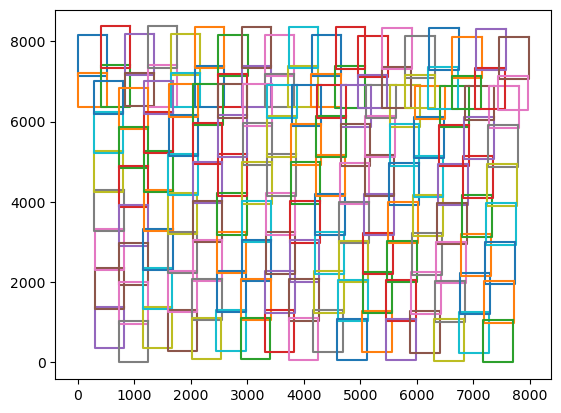

In [4]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

object = 'NGC598'
with fits.open('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage.fits') as f:
    header = f[0].header
    nx = header['NAXIS1']
    ny = header['NAXIS2']
    x0 = header['CRPIX1']
    y0 = header['CRPIX2']
    
image = np.full((nz,ny,nx), np.nan)

path = '/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage/corrdir/'
fig,ax = plt.subplots()
xmax, ymax = 0,0
xmin, ymin = 10000,10000
for i in range(nz):
    file = path + 'hdu0_'+object+'_'+str(i)+'.fits'
    with fits.open(file) as f:
        h = f[0].header
        x, y = int(h['CRPIX1']+x0-1), int(h['CRPIX2']+y0-1)
        nx, ny = h['NAXIS1'], h['NAXIS2']        
        plt.plot([x,x-nx,x-nx,x,x],[y,y,y-ny,y-ny,y])
        xmin = x-nx if (x-nx) < xmin else xmin
        ymin = y-ny if (y-ny) < ymin else ymin
        xmax = x if x > xmax else xmax
        ymax = y if y > ymax else ymax
        ima = f[0].data
        image[i,y-ny:y,x-nx:x] = ima

print(xmin,xmax,ymin,ymax)

In [6]:
# Compute statistics of differences
nz,ny,nx = np.shape(image)
print(nz,nx,ny)
print(np.shape(image[0,:,:]))

med = np.full((nz,nz), np.nan)
disp = np.full((nz,nz), np.nan)
differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(np.isfinite(image[i,:,:]))
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = image[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((np.isfinite(iimages[i]) & np.isfinite(iimages[j])))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:]
            med[i,j]=np.nanmedian(dimage[idx])
            disp[i,j]=np.nanstd(dimage[idx])
            differences.append(dimage[idx])

157 7982 8370
(8370, 7982)
.............................................................................................................................................................

montage  423
skymatch  424
pixmatch  424


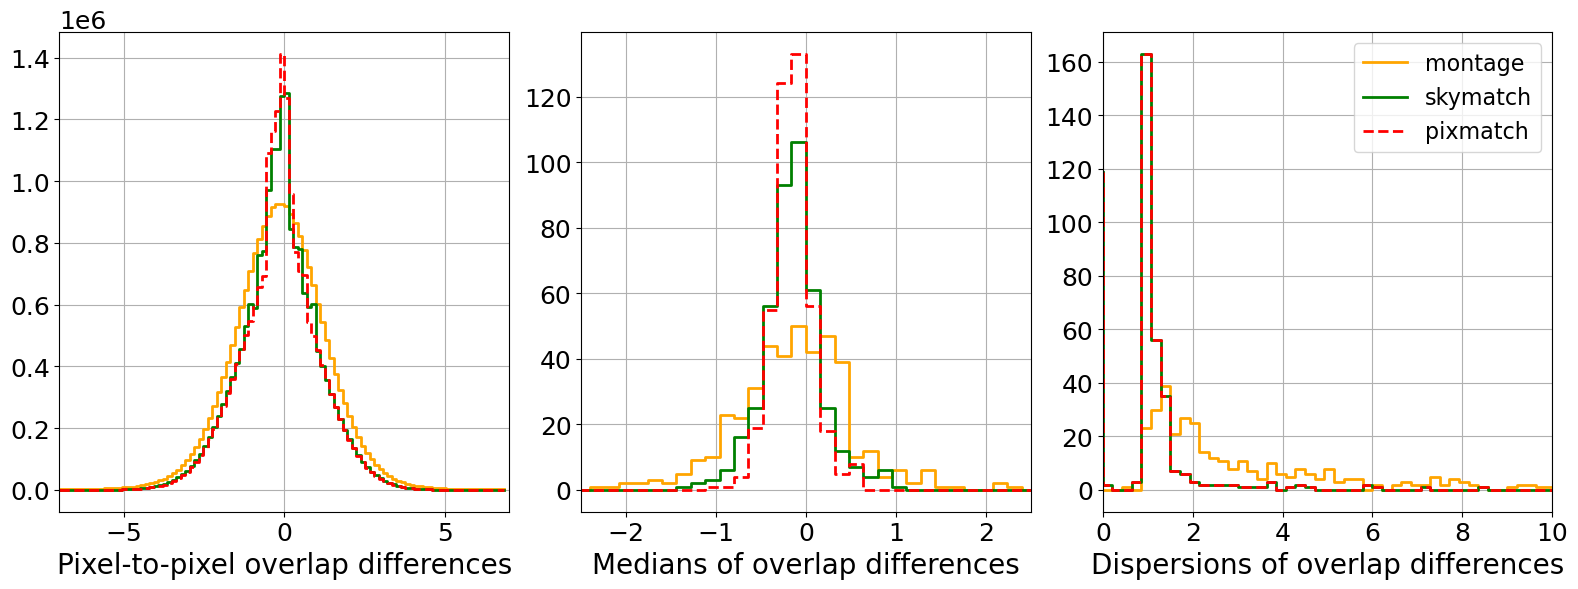

In [7]:
import matplotlib as mpl

object = 'NGC598'

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 3, figsize=(16,6))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
idx = np.abs(diff) < 10
y, x = np.histogram(diff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, label='montage')
skdiff = np.concatenate(sk_differences)
idx = np.abs(skdiff) < 10
y, x = np.histogram(skdiff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, label='skymatch')
pmdiff = np.concatenate(pm_differences)
idx = np.abs(pmdiff) < 10
y, x = np.histogram(pmdiff[idx], bins=100, range=(-7,7))
ax[0].step(x[:-1], y, '--', label='pixmatch')
ax[0].set_xlim(-7,7)
ax[0].set_xlabel('Pixel-to-pixel overlap differences')

# Histogram of medians
mmed = np.concatenate(med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('montage ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y, label='montage')
mmed = np.concatenate(sk_med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('skymatch ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y, label='skymatch')
mmed = np.concatenate(pm_med)
id10 = np.isfinite(mmed) & (np.abs(mmed) < 4); print('pixmatch ', np.sum(id10))
y, x = np.histogram(mmed[id10], bins=50, range=(-4,4))
ax[1].step(x[:-1], y,'--', label='pixmatch')
ax[1].set_xlim(-2.5,2.5)
ax[1].set_xlabel('Medians of overlap differences')

# Histogram of dispersions
dev = np.concatenate(disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y, label='montage')
dev = np.concatenate(sk_disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y, label='skymatch')
dev = np.concatenate(pm_disp)
id0 = np.isfinite(dev) & (dev < 15)& (dev > 0)
y, x = np.histogram(dev[id0], bins=70, range=(0,15))
ax[2].step(x[:-1], y,'--', label='pixmatch')
ax[2].set_xlabel('Dispersions of overlap differences')
ax[2].set_xlim(0,10)

fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
fig.savefig(outdir+object+'_histos.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

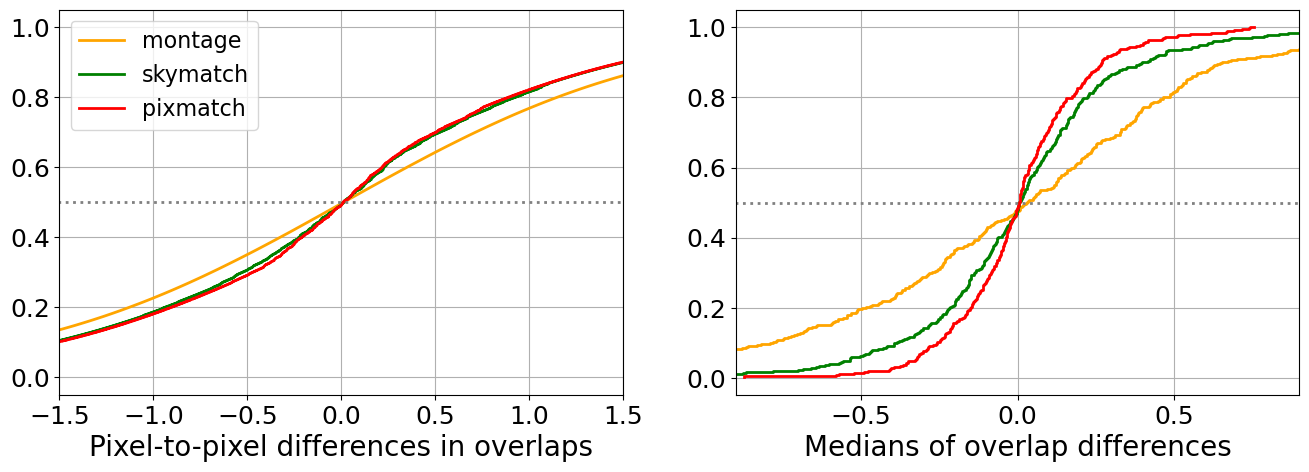

In [8]:
# Cumulative histograms
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib as mpl

object = 'NGC598'

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
ediff = ECDF(diff)
ax[0].step(ediff.x, ediff.y,label='montage')

skdiff = np.concatenate(sk_differences)
eskdiff = ECDF(skdiff)
ax[0].step(eskdiff.x, eskdiff.y,label='skymatch')

pmdiff = np.concatenate(pm_differences)
epmdiff = ECDF(pmdiff)
ax[0].step(epmdiff.x, epmdiff.y,label='pixmatch')

ax[0].legend(fontsize=16, loc='upper left')
ax[0].set_xlim(-1.5,1.5)
ax[0].grid()
ax[0].set_xlabel('Pixel-to-pixel differences in overlaps')
ax[0].axhline(0.5,-1.5,1.5,ls=':',color='grey')


# Histogram of pixel-to-pixel differences
mmed = np.concatenate(med)
idx = np.isfinite(mmed)
emed = ECDF(mmed[idx])
ax[1].step(emed.x, emed.y,label='montage')

mmed = np.concatenate(sk_med)
idx = np.isfinite(mmed)
eskmed = ECDF(mmed[idx])
ax[1].step(eskmed.x, eskmed.y,label='skymatch')

mmed = np.concatenate(pm_med)
idx = np.isfinite(mmed)
epmmed = ECDF(mmed[idx])
ax[1].step(epmmed.x, epmmed.y,label='pixmatch')
ax[1].axhline(0.5,-1.5,1.5,ls=':',color='grey')
ax[1].set_xlim(-0.9,0.9)
ax[1].grid()
ax[1].set_xlabel('Medians of overlap differences')

fig.savefig(outdir+object+'_cum.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()



In [7]:
mmed = np.concatenate(med)
print('Montage ', np.nanstd(mmed))
mmed = np.concatenate(sk_med)
print('Skymatch ', np.nanstd(mmed))
mmed = np.concatenate(pm_med)
print('PixMatch ', np.nanstd(mmed))

Montage  0.8236332693378292
Skymatch  0.3371357564592104
PixMatch  0.22335360128564474


In [13]:
print((0.337/0.223-1)*100)
print((0.824/0.223-1)*100)


51.12107623318387
269.50672645739905


## M 22

In [20]:
from wfiskymatch.scripts import get2MASSfiles
object = 'M22'
size = 2.0
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
get2MASSfiles(object,size=size,outdir=outdir)


Imported:  171  files


In [21]:
# reproject to healpix
from wfiskymatch.scripts import tarfile2healpix
import os
object = 'M22'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
tarfile2healpix(object, outdir=outdir)

# compute offsets
from wfiskymatch.tools import pixmatch
from glob import glob as gb
h5outdir = os.path.join(outdir,object+'_h5')
files = sorted(gb(os.path.join(h5outdir,'*.h5')))
offsets = pixmatch(files, outfile=outdir+object+'_offsets')

# mosaicking 
from wfiskymatch.scripts import makeMosaic
# astropy
makeMosaic(object, outdir)
# pixmatch
makeMosaic(object, outdir, offsetfile=True)

Files will be in  /Users/dfadda/Roman/BgrMatch/Comparison/M22_h5
There is a total of 1140 overlaps


In [64]:
# Skymatch
from wfiskymatch.scripts import runSkymatch
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M22'
runSkymatch(object, outdir,outfile=outdir+object+'_skymatch_offsets')

In [62]:
# Montage
from wfiskymatch.scripts import runMontage
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M22'
runMontage(object, outdir, clean=False)

[struct stat="OK", module="mImgtbl", count=171, nfile=171, nhdu=171, badfits=0, badwcs=0]
[struct stat="OK", module="mMakeHdr", msg="Cube columns exist but are either blank or inconsistent. Outputting 2D only.", count=171, ncube=0, naxis1=7939, naxis2=9066, clon=279.132744, clat=-23.900792, lonsize=2.205278, latsize=2.518333, posang=0.000878, lon1=280.350505, lat1=-25.154761, lon2=277.915025, lat2=-25.154795, lon3=277.938467, lat3=-22.637422, lon4=280.326979, lat4=-22.637389]
[struct stat="OK", module="mProjExec", count=171, failed=0, nooverlap=0]
[struct stat="OK", module="mImgtbl", count=171, nfile=171, nhdu=171, badfits=0, badwcs=0]
[struct stat="OK", module="mAdd", time=3]
[struct stat="OK", module="mOverlaps", count=469]
[struct stat="OK", module="mDiffExec", count=469, failed=0]
[struct stat="OK", module="mFitExec", count=469, failed=0, warning=0, missing=0]
[struct stat="OK", module="mBgModel"]
[struct stat="OK", module="mBgExec", count=171, nocorrection=0, failed=0]
[struct sta

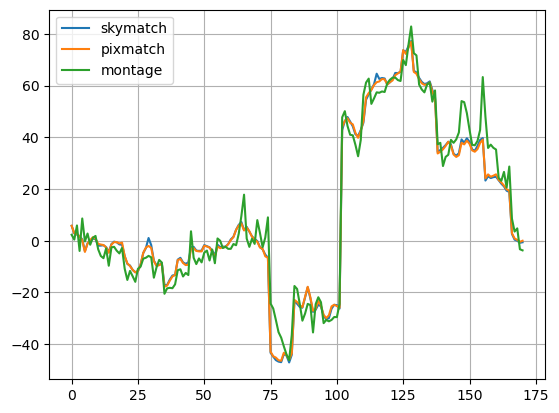

In [17]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M22'
with h5py.File(outdir + object+'_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

index = []
for o, f in zip(offsets, files):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(offsets[idx] - np.median(offsets), label='skymatch')

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

index = []
for o, f in zip(offsets2, files2):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(-offsets2[idx], label='pixmatch' )

from astropy.table import Table
from astropy.io import ascii

data = ascii.read(outdir+object+"_montage/images.tbl")
index = []
for f in data['fname']:
    f0 = f.split('.')[0]
    a,b,fi = f0.split('_')
    index.append(int(fi))

data = ascii.read(outdir+object+"_montage/corrections.tbl")
index1 = data['id']
offsets3 = data['c']
idx = np.argsort(np.array(index1))
o3 = offsets3[idx]
idx = np.argsort(index)
plt.plot(o3[idx] - np.nanmedian(o3) , label='montage')
plt.legend()
plt.grid()
plt.show()


In [1]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from wfiskymatch.skymatch import reprojectAll
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from glob import glob as gb

object = 'M22'
path = '/Users/dfadda/Roman/BgrMatch/Comparison/'
input_data = sorted(gb('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'/*.fits'))

wcs_out, shape_out = find_optimal_celestial_wcs(input_data)
imacube0, footprint0 = reprojectAll(input_data,wcs_out, shape_out=shape_out,
                                reproject_function=reproject_interp)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 


In [2]:
import h5py
object = 'M22'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object + '_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

nz,nx,ny = np.shape(imacube0)
print(nz,nx,ny)


sk_med = np.full((nz,nz), np.nan)
sk_disp = np.full((nz,nz), np.nan)
sk_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] - offsets[i] + offsets[j]
            sk_med[i,j]=np.nanmedian(dimage[idx])
            sk_disp[i,j]=np.nanstd(dimage[idx])
            sk_differences.append(dimage[idx])

171 9066 7938
...........................................................................................................................................................................

In [3]:
nz,ny,nx = np.shape(imacube0)

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

pm_med = np.full((nz, nz), np.nan)
pm_disp = np.full((nz, nz), np.nan)
pm_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1, nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] + offsets2[i] - offsets2[j]
            pm_med[i,j]=np.nanmedian(dimage[idx])
            pm_disp[i,j]=np.nanstd(dimage[idx])
            pm_differences.append(dimage[idx])

...........................................................................................................................................................................

0 7939 0 9066


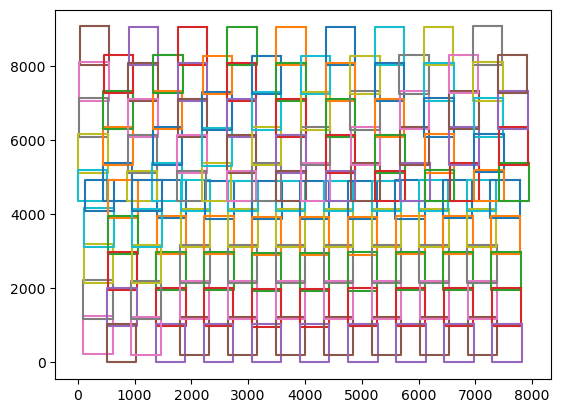

In [4]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

object = 'M22'
with fits.open('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage.fits') as f:
    header = f[0].header
    nx = header['NAXIS1']
    ny = header['NAXIS2']
    x0 = header['CRPIX1']
    y0 = header['CRPIX2']
    
image = np.full((nz,ny,nx), np.nan)

path = '/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage/corrdir/'
fig,ax = plt.subplots()
xmax, ymax = 0,0
xmin, ymin = 10000,10000
for i in range(nz):
    file = path + 'hdu0_'+object+'_'+str(i)+'.fits'
    with fits.open(file) as f:
        h = f[0].header
        x, y = int(h['CRPIX1']+x0-1), int(h['CRPIX2']+y0-1)
        nx, ny = h['NAXIS1'], h['NAXIS2']        
        plt.plot([x,x-nx,x-nx,x,x],[y,y,y-ny,y-ny,y])
        xmin = x-nx if (x-nx) < xmin else xmin
        ymin = y-ny if (y-ny) < ymin else ymin
        xmax = x if x > xmax else xmax
        ymax = y if y > ymax else ymax
        ima = f[0].data
        image[i,y-ny:y,x-nx:x] = ima

print(xmin,xmax,ymin,ymax)

In [5]:
# Compute statistics of differences
nz,ny,nx = np.shape(image)
print(nz,nx,ny)
print(np.shape(image[0,:,:]))

med = np.full((nz,nz), np.nan)
disp = np.full((nz,nz), np.nan)
differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(np.isfinite(image[i,:,:]))
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = image[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((np.isfinite(iimages[i]) & np.isfinite(iimages[j])))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:]
            med[i,j]=np.nanmedian(dimage[idx])
            disp[i,j]=np.nanstd(dimage[idx])
            differences.append(dimage[idx])

171 7939 9066
(9066, 7939)
...........................................................................................................................................................................

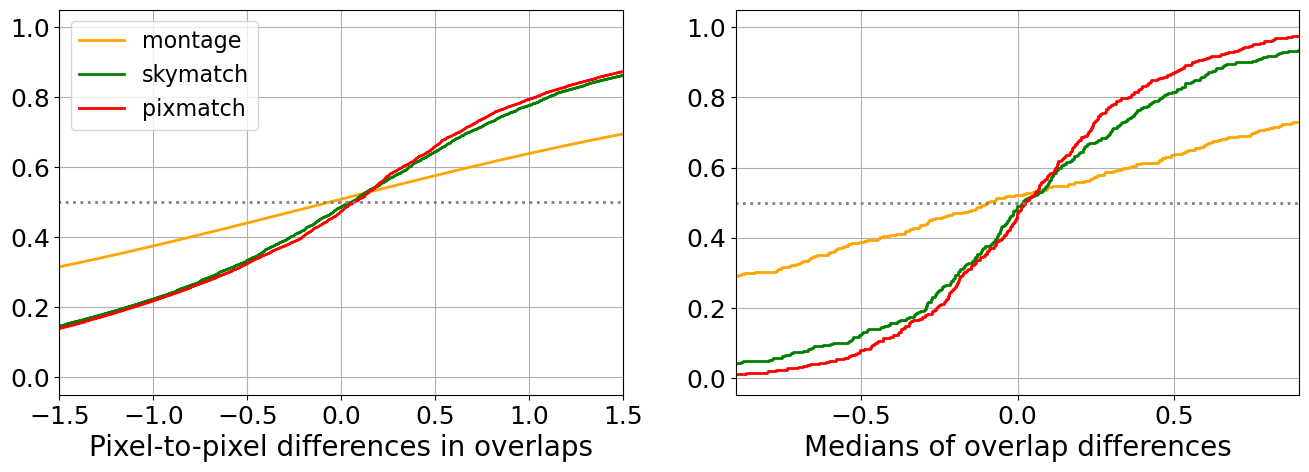

In [6]:
# Cumulative histograms
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib as mpl

object = 'M22'

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
ediff = ECDF(diff)
ax[0].step(ediff.x, ediff.y,label='montage')

skdiff = np.concatenate(sk_differences)
eskdiff = ECDF(skdiff)
ax[0].step(eskdiff.x, eskdiff.y,label='skymatch')

pmdiff = np.concatenate(pm_differences)
epmdiff = ECDF(pmdiff)
ax[0].step(epmdiff.x, epmdiff.y,label='pixmatch')

ax[0].legend(fontsize=16, loc='upper left')
ax[0].set_xlim(-1.5,1.5)
ax[0].grid()
ax[0].set_xlabel('Pixel-to-pixel differences in overlaps')
ax[0].axhline(0.5,-1.5,1.5,ls=':',color='grey')


# Histogram of pixel-to-pixel differences
mmed = np.concatenate(med)
idx = np.isfinite(mmed)
emed = ECDF(mmed[idx])
ax[1].step(emed.x, emed.y,label='montage')

mmed = np.concatenate(sk_med)
idx = np.isfinite(mmed)
eskmed = ECDF(mmed[idx])
ax[1].step(eskmed.x, eskmed.y,label='skymatch')

mmed = np.concatenate(pm_med)
idx = np.isfinite(mmed)
epmmed = ECDF(mmed[idx])
ax[1].step(epmmed.x, epmmed.y,label='pixmatch')
ax[1].axhline(0.5,-1.5,1.5,ls=':',color='grey')
ax[1].set_xlim(-0.9,0.9)
ax[1].grid()
ax[1].set_xlabel('Medians of overlap differences')

fig.savefig(outdir+object+'_cum.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

In [7]:
mmed = np.concatenate(med)
print('Montage ', np.nanstd(mmed))
mmed = np.concatenate(sk_med)
print('Skymatch ', np.nanstd(mmed))
mmed = np.concatenate(pm_med)
print('PixMatch ', np.nanstd(mmed))

Montage  2.0065142513580057
Skymatch  0.6752268558875417
PixMatch  0.40642170612977546


In [12]:
print((0.675/0.406 - 1)*100)
print((2.006/0.406 - 1)*100)

66.25615763546797
394.0886699507388


## M 100

In [43]:
from wfiskymatch.scripts import get2MASSfiles
object = 'M100'
size = 2.0
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
get2MASSfiles(object,size=size,outdir=outdir)


Imported:  153  files


In [44]:
# reproject to healpix
from wfiskymatch.scripts import tarfile2healpix
import os
object = 'M100'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
tarfile2healpix(object, outdir=outdir)

# compute offsets
from wfiskymatch.tools import pixmatch
from glob import glob as gb
h5outdir = os.path.join(outdir,object+'_h5')
files = sorted(gb(os.path.join(h5outdir,'*.h5')))
offsets = pixmatch(files, outfile=outdir+object+'_offsets')

# mosaicking 
from wfiskymatch.scripts import makeMosaic
# astropy
makeMosaic(object, outdir)
# pixmatch
makeMosaic(object, outdir, offsetfile=True)

Files will be in  /Users/dfadda/Roman/BgrMatch/Comparison/M100_h5
There is a total of 996 overlaps


In [1]:
# Skymatch
from wfiskymatch.scripts import runSkymatch
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M100'
runSkymatch(object, outdir,outfile=outdir+object+'_skymatch_offsets')



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


In [2]:
# Montage
from wfiskymatch.scripts import runMontage
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M100'
runMontage(object, outdir, clean=False)

[struct stat="OK", module="mImgtbl", count=153, nfile=153, nhdu=153, badfits=0, badwcs=0]
[struct stat="OK", module="mMakeHdr", msg="Cube columns exist but are either blank or inconsistent. Outputting 2D only.", count=153, ncube=0, naxis1=7854, naxis2=8797, clon=185.777550, clat=15.766481, lonsize=2.181667, latsize=2.443611, posang=359.944565, lon1=186.902874, lat1=14.541119, lon2=184.649774, lat2=14.543217, lon3=184.638586, lat3=16.985993, lon4=186.918973, lat4=16.983870]
[struct stat="OK", module="mProjExec", count=153, failed=0, nooverlap=0]
[struct stat="OK", module="mImgtbl", count=153, nfile=153, nhdu=153, badfits=0, badwcs=0]
[struct stat="OK", module="mAdd", time=3]
[struct stat="OK", module="mOverlaps", count=413]
[struct stat="OK", module="mDiffExec", count=413, failed=0]
[struct stat="OK", module="mFitExec", count=413, failed=0, warning=0, missing=0]
[struct stat="OK", module="mBgModel"]
[struct stat="OK", module="mBgExec", count=153, nocorrection=0, failed=0]
[struct stat="

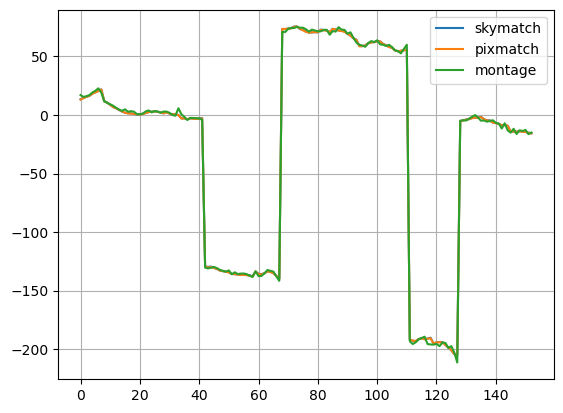

In [13]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M100'
with h5py.File(outdir + object+'_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

index = []
for o, f in zip(offsets, files):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(offsets[idx] - np.median(offsets), label='skymatch')

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

index = []
for o, f in zip(offsets2, files2):
    ff = f.decode('ASCII')
    fn, fi = ff.split('_')
    index.append(int(fi))
    
idx = np.argsort(np.array(index))
plt.plot(-offsets2[idx], label='pixmatch' )

from astropy.table import Table
from astropy.io import ascii

data = ascii.read(outdir+object+"_montage/images.tbl")
index = []
for f in data['fname']:
    f0 = f.split('.')[0]
    a,b,fi = f0.split('_')
    index.append(int(fi))

data = ascii.read(outdir+object+"_montage/corrections.tbl")
index1 = data['id']
offsets3 = data['c']
idx = np.argsort(np.array(index1))
o3 = offsets3[idx]
idx = np.argsort(index)
plt.plot(o3[idx] - np.nanmedian(o3) , label='montage')
plt.legend()
plt.grid()
plt.show()

In [1]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from wfiskymatch.skymatch import reprojectAll
from reproject.mosaicking import find_optimal_celestial_wcs
from reproject import reproject_interp
from glob import glob as gb

object = 'M100'
path = '/Users/dfadda/Roman/BgrMatch/Comparison/'
input_data = sorted(gb('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'/*.fits'))

wcs_out, shape_out = find_optimal_celestial_wcs(input_data)
imacube0, footprint0 = reprojectAll(input_data,wcs_out, shape_out=shape_out,
                                reproject_function=reproject_interp)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 


In [2]:
import h5py
object = 'M100'
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object + '_skymatch_offsets.h5', 'r') as hdf5_file:
    offsets = hdf5_file['offsets'][:]
    files = hdf5_file['files'][:]

nz,nx,ny = np.shape(imacube0)
print(nz,nx,ny)


sk_med = np.full((nz,nz), np.nan)
sk_disp = np.full((nz,nz), np.nan)
sk_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] - offsets[i] + offsets[j]
            sk_med[i,j]=np.nanmedian(dimage[idx])
            sk_disp[i,j]=np.nanstd(dimage[idx])
            sk_differences.append(dimage[idx])

153 8802 7853
.........................................................................................................................................................

In [3]:
nz,ny,nx = np.shape(imacube0)

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
with h5py.File(outdir + object+'_offsets.h5', 'r') as hdf5_file:
    offsets2 = hdf5_file['offsets'][:]
    files2 = hdf5_file['files'][:]

pm_med = np.full((nz, nz), np.nan)
pm_disp = np.full((nz, nz), np.nan)
pm_differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(footprint0[i,:,:] == 1)
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = imacube0[:,imin:imax,jmin:jmax]
    ifootprint = footprint0[:,imin:imax,jmin:jmax]
    for j in range(i+1, nz):
        idx = np.where((ifootprint[i] == 1) & (ifootprint[j] == 1))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:] + offsets2[i] - offsets2[j]
            pm_med[i,j]=np.nanmedian(dimage[idx])
            pm_disp[i,j]=np.nanstd(dimage[idx])
            pm_differences.append(dimage[idx])

.........................................................................................................................................................

0 7854 0 8797


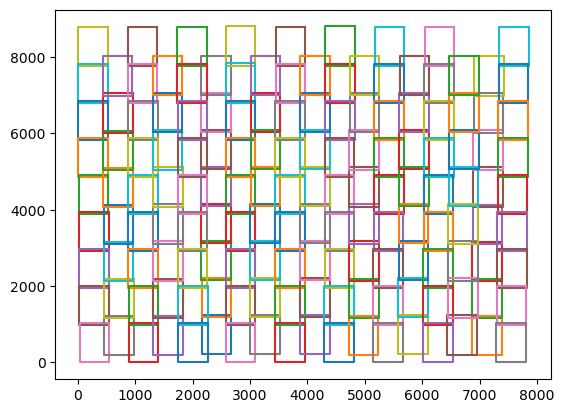

In [4]:
# Create a cube from montage corrected and reprojected images
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

object = 'M100'
with fits.open('/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage.fits') as f:
    header = f[0].header
    nx = header['NAXIS1']
    ny = header['NAXIS2']
    x0 = header['CRPIX1']
    y0 = header['CRPIX2']
    
image = np.full((nz,ny,nx), np.nan)

path = '/Users/dfadda/Roman/BgrMatch/Comparison/'+object+'_montage/corrdir/'
fig,ax = plt.subplots()
xmax, ymax = 0,0
xmin, ymin = 10000,10000
for i in range(nz):
    file = path + 'hdu0_'+object+'_'+str(i)+'.fits'
    with fits.open(file) as f:
        h = f[0].header
        x, y = int(h['CRPIX1']+x0-1), int(h['CRPIX2']+y0-1)
        nx, ny = h['NAXIS1'], h['NAXIS2']        
        plt.plot([x,x-nx,x-nx,x,x],[y,y,y-ny,y-ny,y])
        xmin = x-nx if (x-nx) < xmin else xmin
        ymin = y-ny if (y-ny) < ymin else ymin
        xmax = x if x > xmax else xmax
        ymax = y if y > ymax else ymax
        ima = f[0].data
        image[i,y-ny:y,x-nx:x] = ima

print(xmin,xmax,ymin,ymax)

In [6]:
# Compute statistics of differences
nz,ny,nx = np.shape(image)
print(nz,nx,ny)
print(np.shape(image[0,:,:]))

med = np.full((nz,nz), np.nan)
disp = np.full((nz,nz), np.nan)
differences = []
for i in range(nz):
    print('.',end='')
    idx = np.where(np.isfinite(image[i,:,:]))
    imin,imax = np.min(idx[0]), np.max(idx[0])
    jmin,jmax = np.min(idx[1]), np.max(idx[1])
    iimages = image[:,imin:imax,jmin:jmax]
    for j in range(i+1,nz):
        idx = np.where((np.isfinite(iimages[i]) & np.isfinite(iimages[j])))
        if np.sum(idx) > 0:
            dimage = iimages[i,:,:]-iimages[j,:,:]
            med[i,j]=np.nanmedian(dimage[idx])
            disp[i,j]=np.nanstd(dimage[idx])
            differences.append(dimage[idx])

153 7854 8797
(8797, 7854)
.........................................................................................................................................................

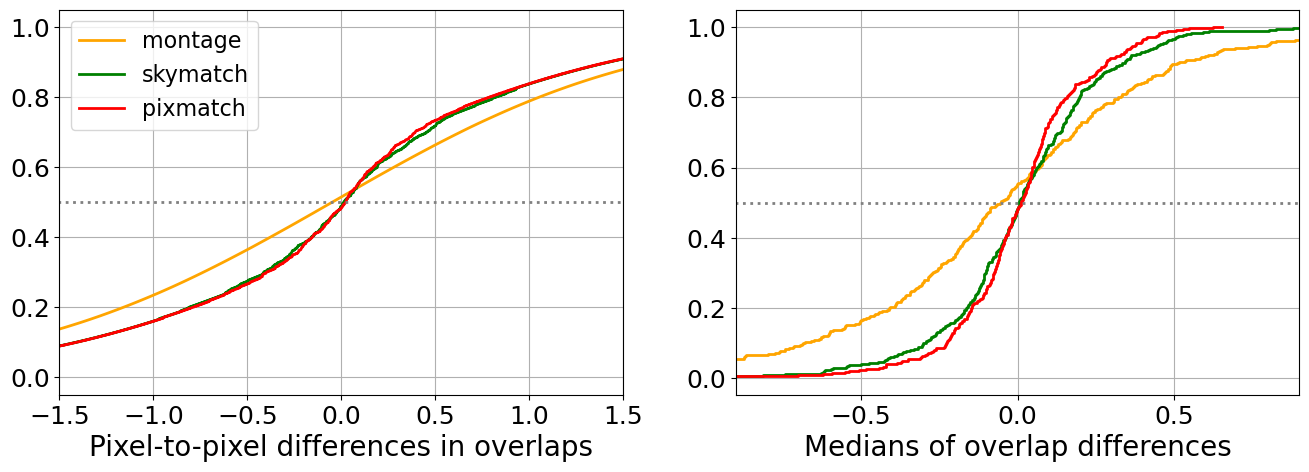

In [24]:
# Cumulative histograms
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib as mpl

object = 'M100'

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
mpl.rc('lines', linewidth=2)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["orange", "green", "red"]) 

fig, ax = plt.subplots(1, 2, figsize=(16,5))

# Histogram of pixel-to-pixel differences
diff = np.concatenate(differences)
ediff = ECDF(diff)
ax[0].step(ediff.x, ediff.y,label='montage')

skdiff = np.concatenate(sk_differences)
eskdiff = ECDF(skdiff)
ax[0].step(eskdiff.x, eskdiff.y,label='skymatch')

pmdiff = np.concatenate(pm_differences)
epmdiff = ECDF(pmdiff)
ax[0].step(epmdiff.x, epmdiff.y,label='pixmatch')

ax[0].legend(fontsize=16, loc='upper left')
ax[0].set_xlim(-1.5,1.5)
ax[0].grid()
ax[0].set_xlabel('Pixel-to-pixel differences in overlaps')
ax[0].axhline(0.5,-1.5,1.5,ls=':',color='grey')


# Histogram of pixel-to-pixel differences
mmed = np.concatenate(med)
idx = np.isfinite(mmed)
emed = ECDF(mmed[idx])
ax[1].step(emed.x, emed.y,label='montage')

mmed = np.concatenate(sk_med)
idx = np.isfinite(mmed)
eskmed = ECDF(mmed[idx])
ax[1].step(eskmed.x, eskmed.y,label='skymatch')

mmed = np.concatenate(pm_med)
idx = np.isfinite(mmed)
epmmed = ECDF(mmed[idx])
ax[1].step(epmmed.x, epmmed.y,label='pixmatch')
ax[1].axhline(0.5,-1.5,1.5,ls=':',color='grey')
ax[1].set_xlim(-0.9,0.9)
ax[1].grid()
ax[1].set_xlabel('Medians of overlap differences')

fig.savefig(outdir+object+'_cum.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

In [7]:
mmed = np.concatenate(med)
print('Montage ', np.nanstd(mmed))
mmed = np.concatenate(sk_med)
print('Skymatch ', np.nanstd(mmed))
mmed = np.concatenate(pm_med)
print('PixMatch ', np.nanstd(mmed))

Montage  0.5667617629591603
Skymatch  0.26611676912468624
PixMatch  0.21494060954228203


In [11]:
print((0.266/0.2149-1)*100)
print((0.567/0.2149-1)*100)

23.778501628664507
163.84364820846903


# Mask point sources

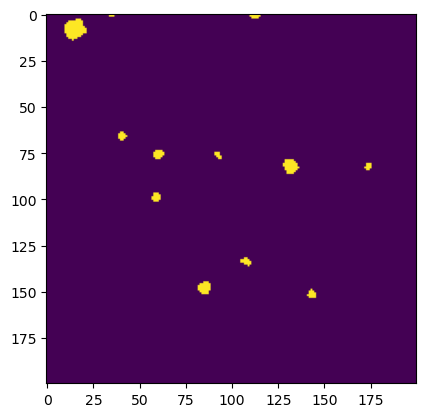

In [7]:
from wfiskymatch.tools import maskSources
from astropy.io import fits
import matplotlib.pyplot as plt


outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
with fits.open(outdir+object+'_montage.fits') as f:
    data = f[0].data

mask = maskSources(data, fwhm=2.0, areathreshold=100, eccthreshold=0.8,nsigma=2)
plt.imshow(mask[1000:1200,1000:1200])

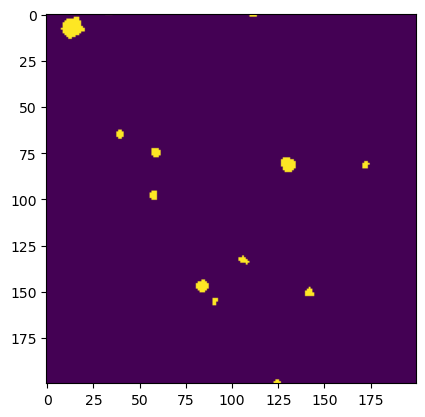

In [8]:
outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'
with fits.open(outdir+object+'_wfiskymatch.fits') as f:
    data = f[0].data

mask = maskSources(data, fwhm=2.0, areathreshold=100, eccthreshold=0.8,nsigma=2)
plt.imshow(mask[1000:1200,1000:1200])

# Metrics

In [69]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

## M 31

526134


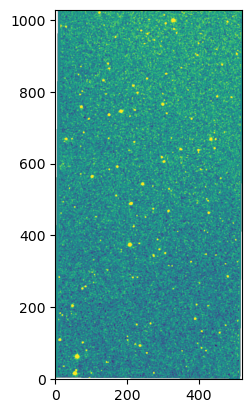

In [96]:
from astropy.io import fits
d=4
with fits.open(outdir+'/'+object+'_montage/corrdir/hdu0_M31_131.fits') as hdu:
    marray = hdu[0].data
mima = marray-np.nanmedian(marray) # montage
#plt.imshow(mima, origin='lower',  vmin=-d, vmax=d)

idx = np.isfinite(marray)
print(np.sum(idx))
mima[~idx] = np.nan
plt.imshow(mima, origin='lower',  vmin=-d, vmax=d)


In [14]:
# Build cube of images
nima = 167
cube = np.empty((nima, 8304, 7946))
print(np.shape(cube))
#8304/2, 7946/2

(167, 8304, 7946)


(8304, 7946)


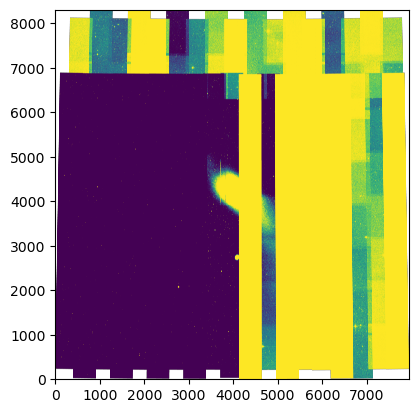

In [11]:
with fits.open(outdir+'/'+object+'_montage/'+object+'_uncorrected.fits') as hdu:
    marray = hdu[0].data
mima = marray-np.nanmedian(marray) # montage
print(np.shape(mima))
plt.imshow(mima, origin='lower',  vmin=-d, vmax=d)

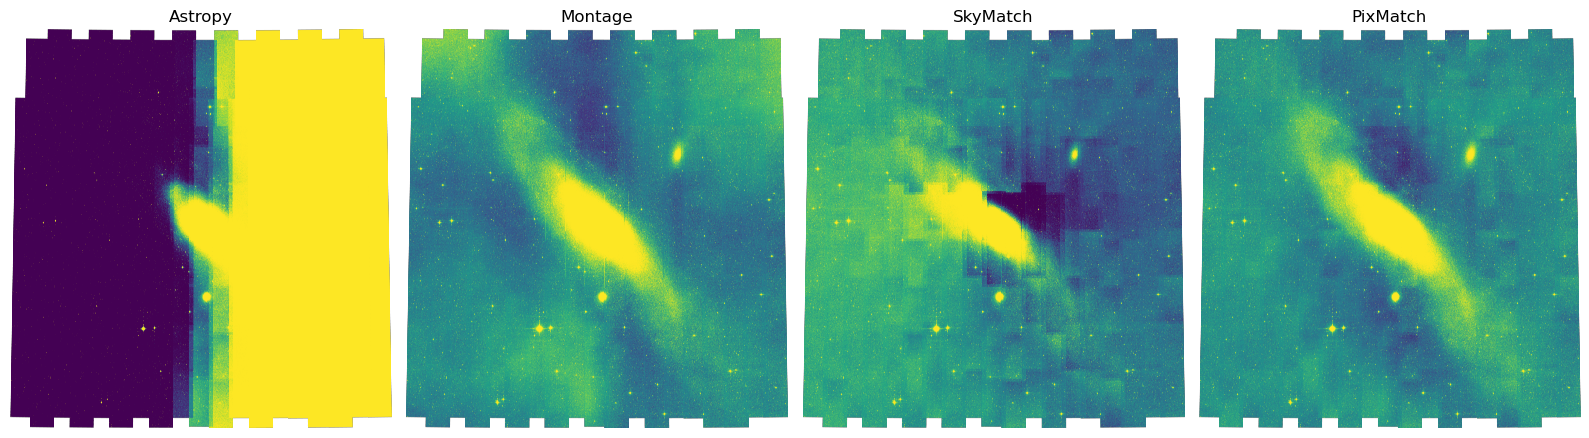

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M31'

with fits.open(outdir+object+'_montage.fits') as hdu:
    marray = hdu[0].data
with fits.open(outdir+object+'_skymatch.fits') as hdu:
    sarray = hdu[0].data
with fits.open(outdir+object+'_wfiskymatch.fits') as hdu:
    warray = hdu[0].data
with fits.open(outdir+object+'_astropy.fits') as hdu:
    aarray = hdu[0].data
aima = aarray-np.nanmedian(aarray) # astropy
mima = marray-np.nanmedian(marray) # montage
sima = sarray-np.nanmedian(sarray) # skymatch
wima = warray-np.nanmedian(warray) # wfiskymatch

    
import numpy as np
fig, axs = plt.subplots(1, 4, figsize=(16,8))
d = 4
im1 = axs[0].imshow(aima, origin='lower',  vmin=-d, vmax=d)
axs[0].set_title('Astropy')
im2 = axs[1].imshow(mima, origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('Montage')
im3 = axs[2].imshow(sima, origin='lower',  vmin=-d, vmax=d)
axs[2].set_title('SkyMatch')
im4 = axs[3].imshow(wima, origin='lower',  vmin=-d, vmax=d)
axs[3].set_title('PixMatch')
for i in range(4):
    axs[i].axis('off')
fig.tight_layout()
fig.savefig(outdir+object+'_2MASS_comparison.png',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


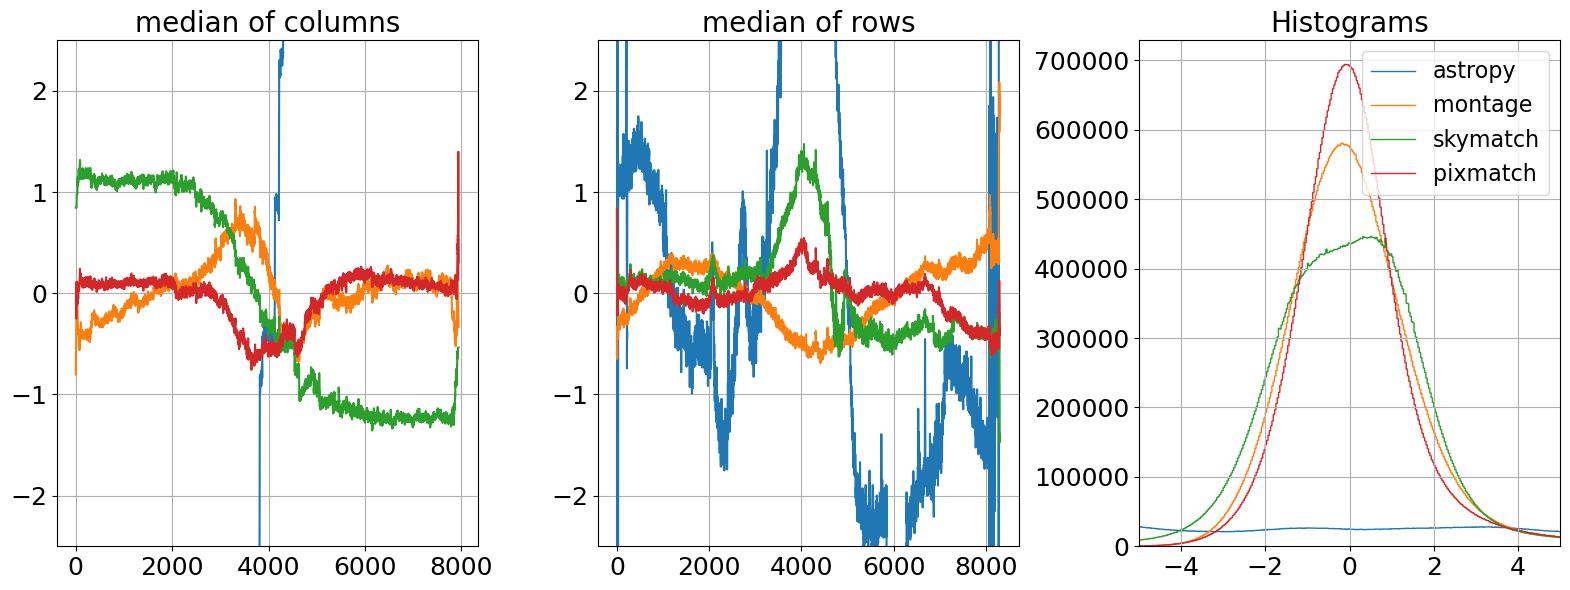

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

ax[0].plot(np.nanmedian(aima, axis=0), label='astropy')
ax[0].plot(np.nanmedian(mima, axis=0), label='montage')
ax[0].plot(np.nanmedian(sima, axis=0), label='skymatch')
ax[0].plot(np.nanmedian(wima, axis=0), label='pixmatch')
ax[1].plot(np.nanmedian(aima, axis=1), label='astropy')
ax[1].plot(np.nanmedian(mima, axis=1), label='montage')
ax[1].plot(np.nanmedian(sima, axis=1), label='skymatch')
ax[1].plot(np.nanmedian(wima, axis=1), label='pixmatch')
ax[0].set_ylim(-2.5,2.5)
ax[1].set_ylim(-2.5,2.5)
ax[0].set_title('median of columns')
ax[1].set_title('median of rows')
# distribution
nbins = 800
idx = np.isfinite(aima) & (aima >-10) & (aima < 15)
counts, bins = np.histogram(aima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='astropy')
idx = np.isfinite(mima) & (mima >-10) & (mima < 15)
counts, bins = np.histogram(mima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='montage')
idx = np.isfinite(sima) & (sima >-10) & (sima < 15)
counts, bins = np.histogram(sima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='skymatch')
idx = np.isfinite(wima) & (wima >-10) & (wima < 15)
counts, bins = np.histogram(wima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='pixmatch')
ax[2].set_xlim(-5,5)
ax[2].set_title('Histograms')
fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
fig.savefig(outdir+object+'_plots.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

## M 22

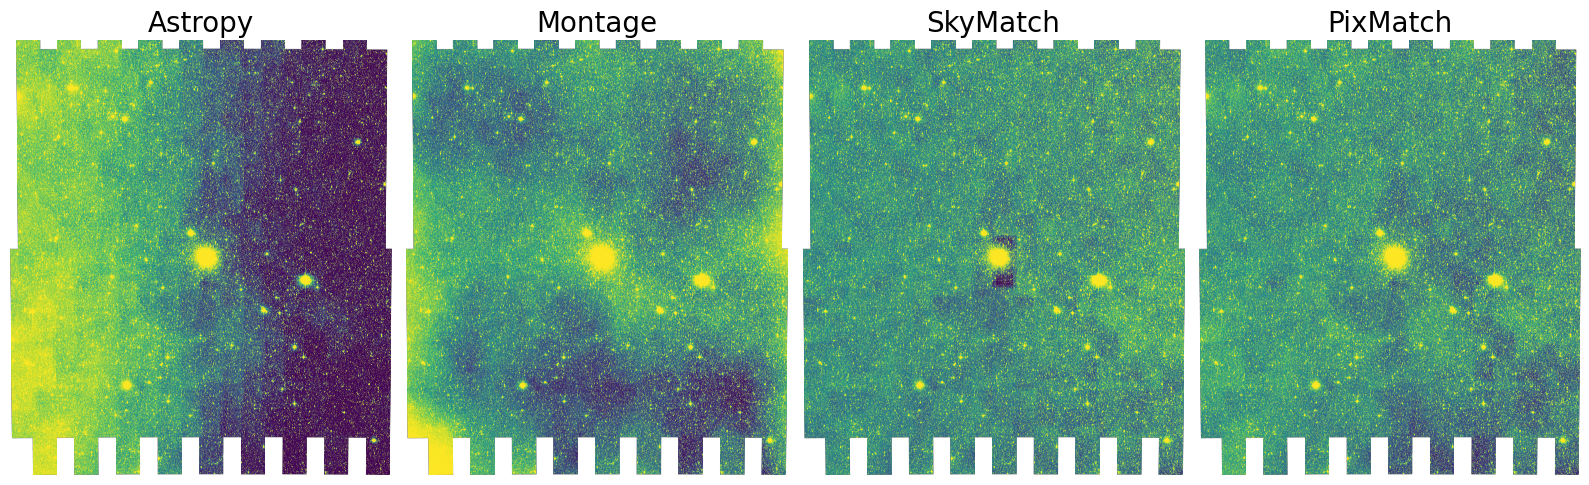

In [88]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M22'

with fits.open(outdir+object+'_montage.fits') as hdu:
    marray = hdu[0].data
with fits.open(outdir+object+'_skymatch.fits') as hdu:
    sarray = hdu[0].data
with fits.open(outdir+object+'_wfiskymatch.fits') as hdu:
    warray = hdu[0].data
with fits.open(outdir+object+'_astropy.fits') as hdu:
    aarray = hdu[0].data
aima = aarray-np.nanmedian(aarray) # astropy
mima = marray-np.nanmedian(marray) # montage
sima = sarray-np.nanmedian(sarray) # skymatch
wima = warray-np.nanmedian(warray) # wfiskymatch

    
import numpy as np
fig, axs = plt.subplots(1, 4, figsize=(16,8))
d = 4
im1 = axs[0].imshow(aima, origin='lower',  vmin=-d, vmax=d)
axs[0].set_title('Astropy')#,fontsize='x-large')
im2 = axs[1].imshow(mima, origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('Montage')#,fontsize='x-large')
im3 = axs[2].imshow(sima, origin='lower',  vmin=-d, vmax=d)
axs[2].set_title('SkyMatch')#,fontsize='x-large')
im4 = axs[3].imshow(wima, origin='lower',  vmin=-d, vmax=d)
axs[3].set_title('PixMatch')#,fontsize='x-large')
for i in range(4):
    axs[i].axis('off')
fig.tight_layout()
fig.savefig(outdir+object+'_2MASS_comparison.png',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


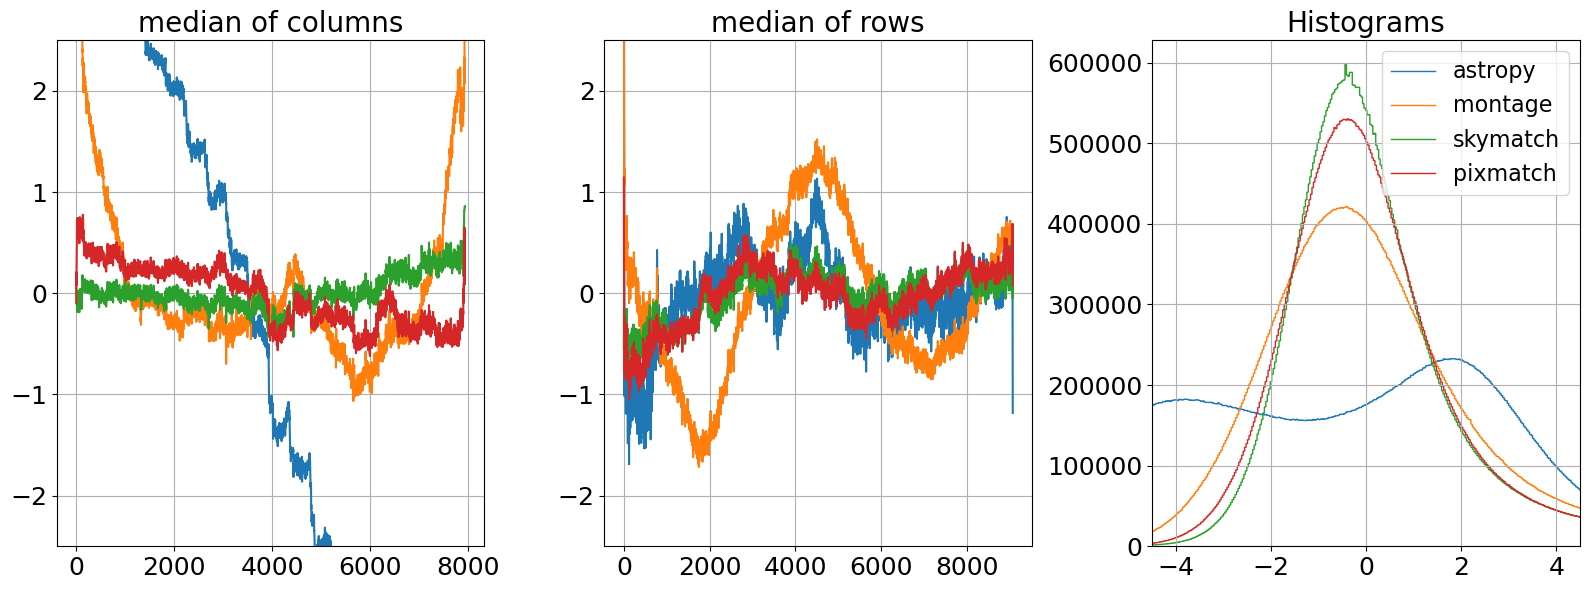

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

ax[0].plot(np.nanmedian(aima, axis=0), label='astropy')
ax[0].plot(np.nanmedian(mima, axis=0), label='montage')
ax[0].plot(np.nanmedian(sima, axis=0), label='skymatch')
ax[0].plot(np.nanmedian(wima, axis=0), label='pixmatch')
ax[1].plot(np.nanmedian(aima, axis=1), label='astropy')
ax[1].plot(np.nanmedian(mima, axis=1), label='montage')
ax[1].plot(np.nanmedian(sima, axis=1), label='skymatch')
ax[1].plot(np.nanmedian(wima, axis=1), label='pixmatch')
ax[0].set_ylim(-2.5,2.5)
ax[1].set_ylim(-2.5,2.5)
ax[0].set_title('median of columns')#,fontsize='x-large')
ax[1].set_title('median of rows')#,fontsize='x-large')
# distribution
nbins = 800
idx = np.isfinite(aima) & (aima >-10) & (aima < 15)
counts, bins = np.histogram(aima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='astropy')
idx = np.isfinite(mima) & (mima >-10) & (mima < 15)
counts, bins = np.histogram(mima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='montage')
idx = np.isfinite(sima) & (sima >-10) & (sima < 15)
counts, bins = np.histogram(sima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='skymatch')
idx = np.isfinite(wima) & (wima >-10) & (wima < 15)
counts, bins = np.histogram(wima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='pixmatch')
ax[2].set_xlim(-4.5,4.5)
ax[2].set_title('Histograms')
fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
fig.savefig(outdir+object+'_plots.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

## NGC 598

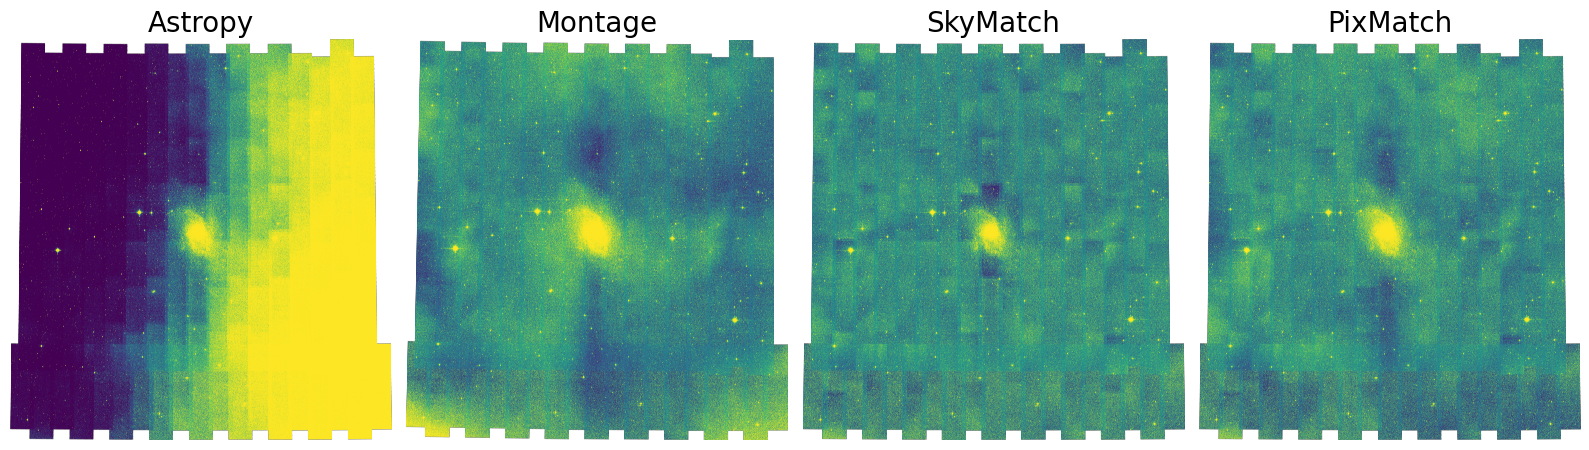

In [90]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'NGC598'

with fits.open(outdir+object+'_montage.fits') as hdu:
    marray = hdu[0].data
with fits.open(outdir+object+'_skymatch.fits') as hdu:
    sarray = hdu[0].data
with fits.open(outdir+object+'_wfiskymatch.fits') as hdu:
    warray = hdu[0].data
with fits.open(outdir+object+'_astropy.fits') as hdu:
    aarray = hdu[0].data
aima = aarray-np.nanmedian(aarray) # astropy
mima = marray-np.nanmedian(marray) # montage
sima = sarray-np.nanmedian(sarray) # skymatch
wima = warray-np.nanmedian(warray) # wfiskymatch

    
import numpy as np
fig, axs = plt.subplots(1, 4, figsize=(16,8))
d = 2
im1 = axs[0].imshow(aima, origin='lower',  vmin=-d, vmax=d)
axs[0].set_title('Astropy')#,fontsize='x-large')
im2 = axs[1].imshow(mima, origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('Montage')#,fontsize='x-large')
im3 = axs[2].imshow(sima, origin='lower',  vmin=-d, vmax=d)
axs[2].set_title('SkyMatch')#,fontsize='x-large')
im4 = axs[3].imshow(wima, origin='lower',  vmin=-d, vmax=d)
axs[3].set_title('PixMatch')#,fontsize='x-large')
for i in range(4):
    axs[i].axis('off')
fig.tight_layout()
fig.savefig(outdir+object+'_2MASS_comparison.png',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


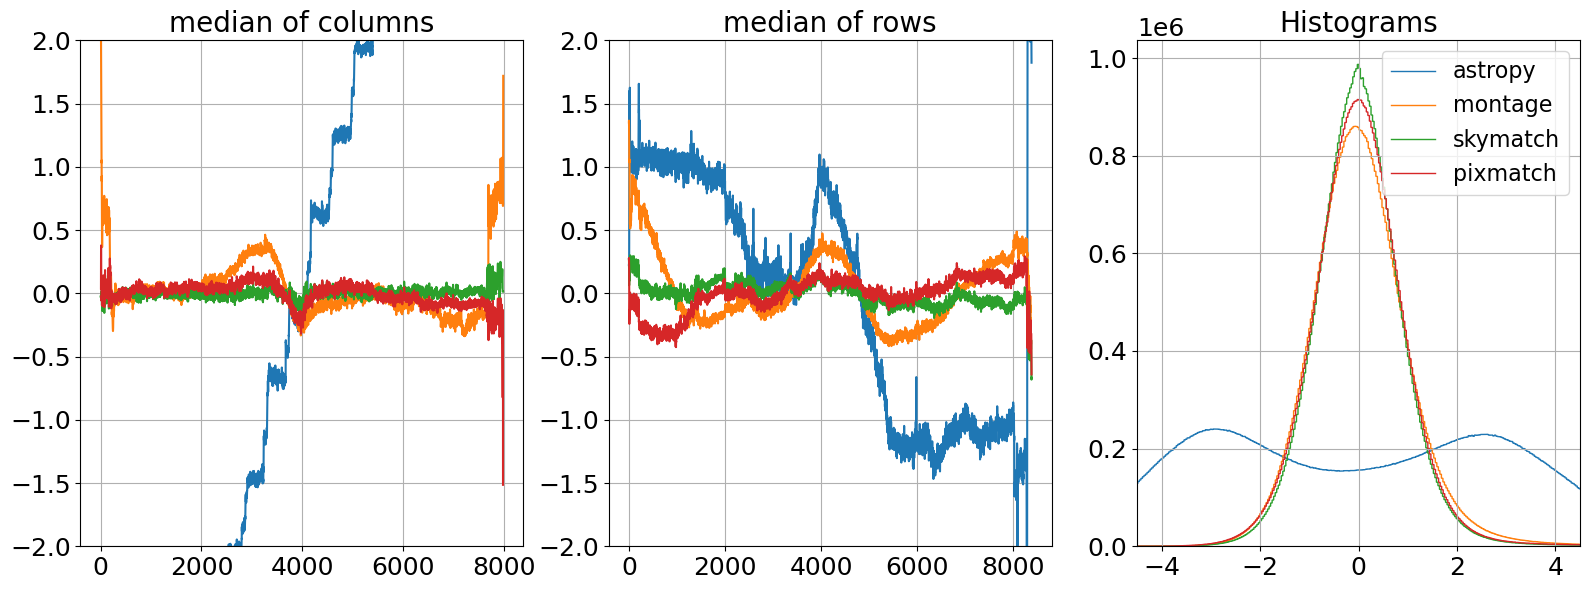

In [91]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

ax[0].plot(np.nanmedian(aima, axis=0), label='astropy')
ax[0].plot(np.nanmedian(mima, axis=0), label='montage')
ax[0].plot(np.nanmedian(sima, axis=0), label='skymatch')
ax[0].plot(np.nanmedian(wima, axis=0), label='pixmatch')
ax[1].plot(np.nanmedian(aima, axis=1), label='astropy')
ax[1].plot(np.nanmedian(mima, axis=1), label='montage')
ax[1].plot(np.nanmedian(sima, axis=1), label='skymatch')
ax[1].plot(np.nanmedian(wima, axis=1), label='pixmatch')
ax[0].set_ylim(-2.,2.)
ax[1].set_ylim(-2.,2.)
ax[0].set_title('median of columns')#,fontsize='x-large')
ax[1].set_title('median of rows')#,fontsize='x-large')
# distribution
nbins = 800
idx = np.isfinite(aima) & (aima >-10) & (aima < 15)
counts, bins = np.histogram(aima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='astropy')
idx = np.isfinite(mima) & (mima >-10) & (mima < 15)
counts, bins = np.histogram(mima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='montage')
idx = np.isfinite(sima) & (sima >-10) & (sima < 15)
counts, bins = np.histogram(sima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='skymatch')
idx = np.isfinite(wima) & (wima >-10) & (wima < 15)
counts, bins = np.histogram(wima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='pixmatch')
ax[2].set_xlim(-4.5,4.5)
ax[2].set_title('Histograms')
fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
fig.savefig(outdir+object+'_plots.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

## M100

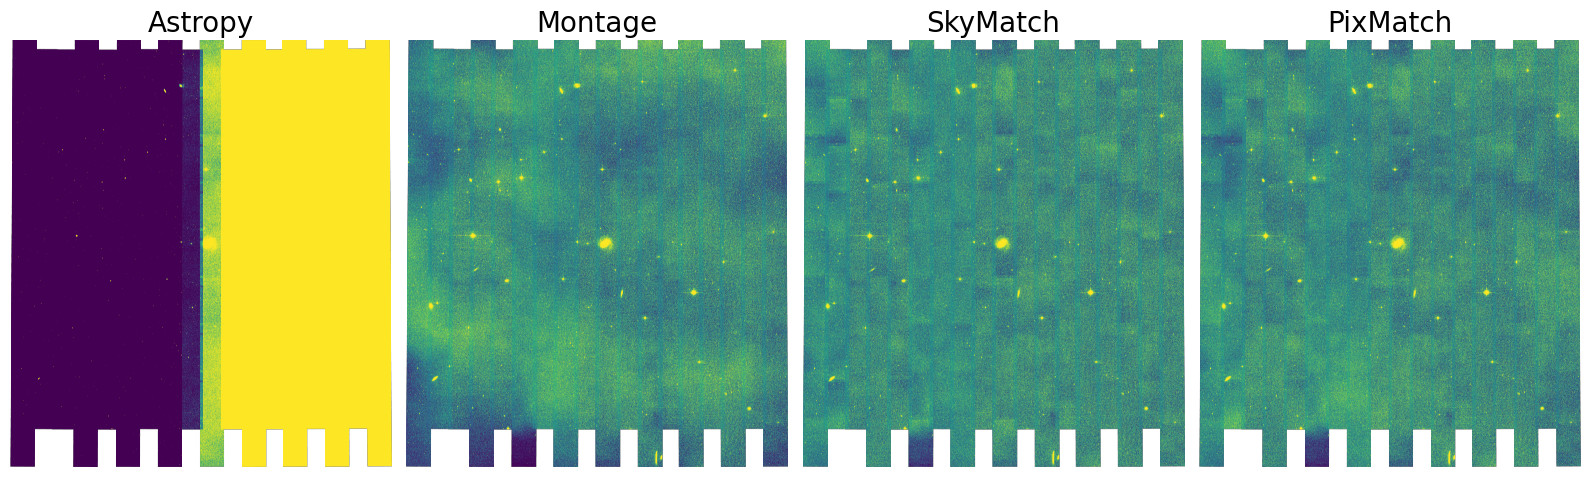

In [92]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

outdir = '/Users/dfadda/Roman/BgrMatch/Comparison/'
object = 'M100'

with fits.open(outdir+object+'_montage.fits') as hdu:
    marray = hdu[0].data
with fits.open(outdir+object+'_skymatch.fits') as hdu:
    sarray = hdu[0].data
with fits.open(outdir+object+'_wfiskymatch.fits') as hdu:
    warray = hdu[0].data
with fits.open(outdir+object+'_astropy.fits') as hdu:
    aarray = hdu[0].data
aima = aarray-np.nanmedian(aarray) # astropy
mima = marray-np.nanmedian(marray) # montage
sima = sarray-np.nanmedian(sarray) # skymatch
wima = warray-np.nanmedian(warray) # wfiskymatch

    
import numpy as np
fig, axs = plt.subplots(1, 4, figsize=(16,8))
d = 2
im1 = axs[0].imshow(aima, origin='lower',  vmin=-d, vmax=d)
axs[0].set_title('Astropy')#,fontsize='x-large')
im2 = axs[1].imshow(mima, origin='lower',  vmin=-d, vmax=d)
axs[1].set_title('Montage')#,fontsize='x-large')
im3 = axs[2].imshow(sima, origin='lower',  vmin=-d, vmax=d)
axs[2].set_title('SkyMatch')#,fontsize='x-large')
im4 = axs[3].imshow(wima, origin='lower',  vmin=-d, vmax=d)
axs[3].set_title('PixMatch')#,fontsize='x-large')
for i in range(4):
    axs[i].axis('off')
fig.tight_layout()
fig.savefig(outdir+object+'_2MASS_comparison.png',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:1217: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a, func=_nanmedian, keepdims=keepdims,


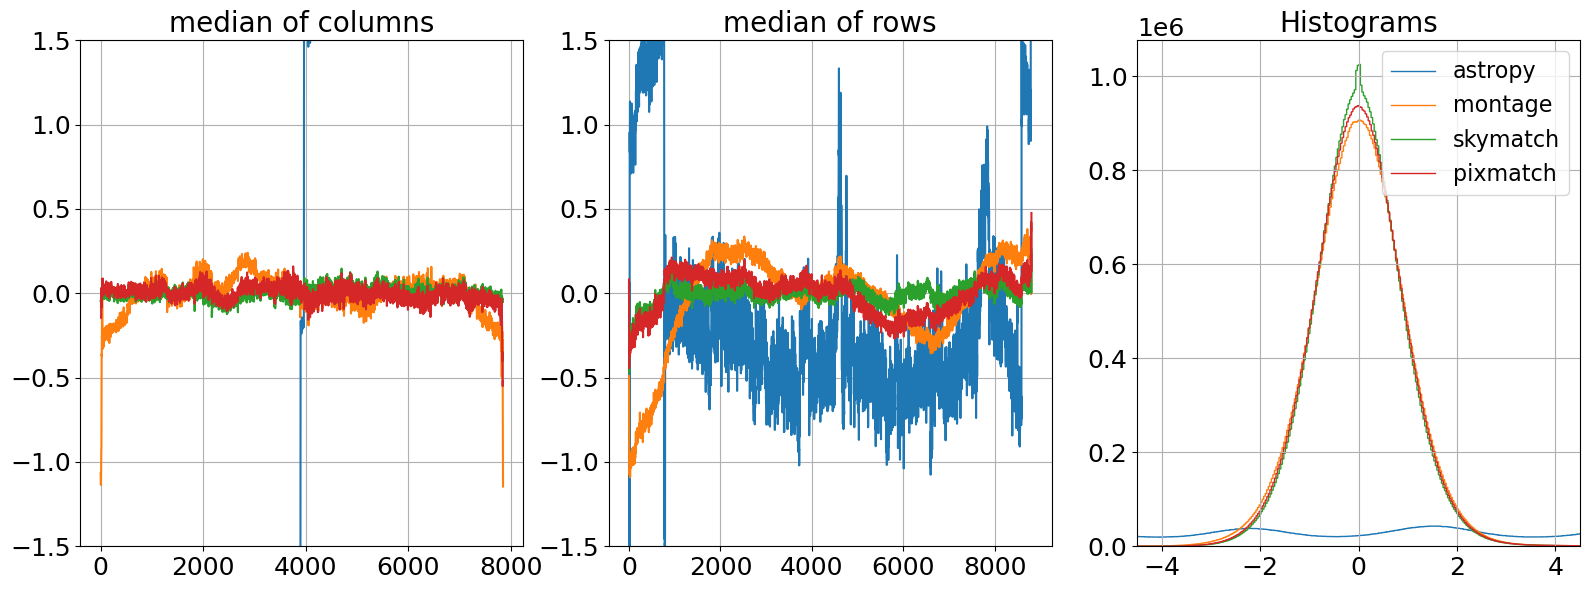

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(16,6))

ax[0].plot(np.nanmedian(aima, axis=0), label='astropy')
ax[0].plot(np.nanmedian(mima, axis=0), label='montage')
ax[0].plot(np.nanmedian(sima, axis=0), label='skymatch')
ax[0].plot(np.nanmedian(wima, axis=0), label='pixmatch')
ax[1].plot(np.nanmedian(aima, axis=1), label='astropy')
ax[1].plot(np.nanmedian(mima, axis=1), label='montage')
ax[1].plot(np.nanmedian(sima, axis=1), label='skymatch')
ax[1].plot(np.nanmedian(wima, axis=1), label='pixmatch')
ax[0].set_ylim(-1.5,1.5)
ax[1].set_ylim(-1.5,1.5)
ax[0].set_title('median of columns')#,fontsize='x-large')
ax[1].set_title('median of rows')#,fontsize='x-large')
# distribution
nbins = 800
idx = np.isfinite(aima) & (aima >-10) & (aima < 15)
counts, bins = np.histogram(aima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='astropy')
idx = np.isfinite(mima) & (mima >-10) & (mima < 15)
counts, bins = np.histogram(mima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='montage')
idx = np.isfinite(sima) & (sima >-10) & (sima < 15)
counts, bins = np.histogram(sima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='skymatch')
idx = np.isfinite(wima) & (wima >-10) & (wima < 15)
counts, bins = np.histogram(wima[idx], bins=nbins)
ax[2].stairs(counts, bins, label='pixmatch')
ax[2].set_xlim(-4.5,4.5)
ax[2].set_title('Histograms')
fig.tight_layout()
plt.legend(fontsize=16, loc='upper right')
for i in range(3):
    ax[i].grid()
fig.savefig(outdir+object+'_plots.pdf',bbox_inches="tight", pad_inches=0.2, transparent=True)
plt.show()

# Working with ASDF files

## Creation of HDF5 Healpix files

In [8]:
# Using simulated files of a star cluster (4 dithers)
from glob import glob as gb
import os
from wfiskymatch.tools import asdf2healpix
path = '/grp/roman/SCIENCE_PLATFORM_DATA/roman-17.0.0/Old/'
outdir = '/Users/dfadda/Roman/BgrMatch/RomanISim/'
files = sorted(gb(os.path.join(path,'r0003201001001001004*wfi*_cal*asdf')))
for file in files:
    asdf2healpix(file, outdir)

file  r0003201001001001004_0001_wfi01_cal  read in  21.73327898979187


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi01_cal.h5 time:  6.66872763633728
file  r0003201001001001004_0001_wfi02_cal  read in  21.09325885772705


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi02_cal.h5 time:  6.544434070587158
file  r0003201001001001004_0001_wfi03_cal  read in  21.159740924835205


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi03_cal.h5 time:  6.557230710983276
file  r0003201001001001004_0001_wfi04_cal  read in  27.225987195968628


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi04_cal.h5 time:  6.762937068939209
file  r0003201001001001004_0001_wfi05_cal  read in  22.76123309135437


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi05_cal.h5 time:  6.670230865478516
file  r0003201001001001004_0001_wfi06_cal  read in  22.409631967544556


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi06_cal.h5 time:  6.525996923446655
file  r0003201001001001004_0001_wfi07_cal  read in  21.56105399131775


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi07_cal.h5 time:  6.735991716384888
file  r0003201001001001004_0001_wfi08_cal  read in  22.326730012893677


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi08_cal.h5 time:  6.5187249183654785
file  r0003201001001001004_0001_wfi09_cal  read in  22.255842208862305


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi09_cal.h5 time:  6.563179969787598
file  r0003201001001001004_0001_wfi10_cal  read in  23.02138090133667


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi10_cal.h5 time:  6.699425935745239
file  r0003201001001001004_0001_wfi11_cal  read in  21.949054956436157


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi11_cal.h5 time:  6.4577202796936035
file  r0003201001001001004_0001_wfi12_cal  read in  19.884580850601196


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi12_cal.h5 time:  6.452822923660278
file  r0003201001001001004_0001_wfi13_cal  read in  22.27428889274597


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi13_cal.h5 time:  6.7055768966674805
file  r0003201001001001004_0001_wfi14_cal  read in  22.116518259048462


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi14_cal.h5 time:  6.341491937637329
file  r0003201001001001004_0001_wfi15_cal  read in  21.517629861831665


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi15_cal.h5 time:  6.44218111038208
file  r0003201001001001004_0001_wfi16_cal  read in  20.977802991867065


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi16_cal.h5 time:  6.651495933532715
file  r0003201001001001004_0001_wfi17_cal  read in  21.893770933151245


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi17_cal.h5 time:  6.475637912750244
file  r0003201001001001004_0001_wfi18_cal  read in  22.359046936035156


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0001_wfi18_cal.h5 time:  6.491788864135742
file  r0003201001001001004_0002_wfi01_cal  read in  22.633764266967773


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi01_cal.h5 time:  6.646888971328735
file  r0003201001001001004_0002_wfi02_cal  read in  22.172413110733032


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi02_cal.h5 time:  6.661993980407715
file  r0003201001001001004_0002_wfi03_cal  read in  22.07095718383789


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi03_cal.h5 time:  6.533814191818237
file  r0003201001001001004_0002_wfi04_cal  read in  22.484626054763794


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi04_cal.h5 time:  6.57509708404541
file  r0003201001001001004_0002_wfi05_cal  read in  21.973798751831055


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi05_cal.h5 time:  6.427455902099609
file  r0003201001001001004_0002_wfi06_cal  read in  22.940829277038574


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi06_cal.h5 time:  6.506843090057373
file  r0003201001001001004_0002_wfi07_cal  read in  21.872535943984985


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi07_cal.h5 time:  6.508332014083862
file  r0003201001001001004_0002_wfi08_cal  read in  23.092549085617065


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi08_cal.h5 time:  6.837666749954224
file  r0003201001001001004_0002_wfi09_cal  read in  24.286946773529053


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi09_cal.h5 time:  6.560322999954224
file  r0003201001001001004_0002_wfi10_cal  read in  22.15533685684204


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi10_cal.h5 time:  6.577699661254883
file  r0003201001001001004_0002_wfi11_cal  read in  20.795343160629272


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi11_cal.h5 time:  6.447612047195435
file  r0003201001001001004_0002_wfi12_cal  read in  21.142488718032837


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi12_cal.h5 time:  6.520118951797485
file  r0003201001001001004_0002_wfi13_cal  read in  22.974814891815186


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi13_cal.h5 time:  6.5862860679626465
file  r0003201001001001004_0002_wfi14_cal  read in  21.48639988899231


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi14_cal.h5 time:  6.478627920150757
file  r0003201001001001004_0002_wfi15_cal  read in  23.380768060684204


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi15_cal.h5 time:  6.45395302772522
file  r0003201001001001004_0002_wfi16_cal  read in  25.95756196975708


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi16_cal.h5 time:  6.491683006286621
file  r0003201001001001004_0002_wfi17_cal  read in  25.01952600479126


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi17_cal.h5 time:  6.557429075241089
file  r0003201001001001004_0002_wfi18_cal  read in  23.57217288017273


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0002_wfi18_cal.h5 time:  6.509345054626465
file  r0003201001001001004_0003_wfi01_cal  read in  23.098809957504272


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi01_cal.h5 time:  6.59145975112915
file  r0003201001001001004_0003_wfi02_cal  read in  24.811112880706787


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi02_cal.h5 time:  6.6680309772491455
file  r0003201001001001004_0003_wfi03_cal  read in  24.625490188598633


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi03_cal.h5 time:  6.572448015213013
file  r0003201001001001004_0003_wfi04_cal  read in  22.224300146102905


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi04_cal.h5 time:  6.4518609046936035
file  r0003201001001001004_0003_wfi05_cal  read in  29.737180948257446


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi05_cal.h5 time:  6.700562238693237
file  r0003201001001001004_0003_wfi06_cal  read in  25.45936107635498


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi06_cal.h5 time:  6.4997007846832275
file  r0003201001001001004_0003_wfi07_cal  read in  25.537871837615967


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi07_cal.h5 time:  6.61248517036438
file  r0003201001001001004_0003_wfi08_cal  read in  23.56820583343506


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi08_cal.h5 time:  6.748363018035889
file  r0003201001001001004_0003_wfi09_cal  read in  22.573004961013794


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi09_cal.h5 time:  6.586497068405151
file  r0003201001001001004_0003_wfi10_cal  read in  22.769900798797607


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi10_cal.h5 time:  6.805991888046265
file  r0003201001001001004_0003_wfi11_cal  read in  21.543041944503784


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi11_cal.h5 time:  6.697760105133057
file  r0003201001001001004_0003_wfi12_cal  read in  21.617014169692993


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi12_cal.h5 time:  6.419146776199341
file  r0003201001001001004_0003_wfi13_cal  read in  22.970101594924927


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi13_cal.h5 time:  6.572371959686279
file  r0003201001001001004_0003_wfi14_cal  read in  20.293796062469482


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi14_cal.h5 time:  6.673243999481201
file  r0003201001001001004_0003_wfi15_cal  read in  21.215919971466064


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi15_cal.h5 time:  6.493298053741455
file  r0003201001001001004_0003_wfi16_cal  read in  21.37594699859619


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi16_cal.h5 time:  6.600305795669556
file  r0003201001001001004_0003_wfi17_cal  read in  22.289329290390015


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi17_cal.h5 time:  6.650843858718872
file  r0003201001001001004_0003_wfi18_cal  read in  22.550090789794922


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0003_wfi18_cal.h5 time:  6.519560098648071
file  r0003201001001001004_0004_wfi01_cal  read in  24.399227142333984


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi01_cal.h5 time:  6.78362512588501
file  r0003201001001001004_0004_wfi02_cal  read in  20.85413098335266


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi02_cal.h5 time:  6.601435899734497
file  r0003201001001001004_0004_wfi03_cal  read in  27.550121068954468


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi03_cal.h5 time:  6.673852920532227
file  r0003201001001001004_0004_wfi04_cal  read in  22.931631088256836


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi04_cal.h5 time:  6.578863143920898
file  r0003201001001001004_0004_wfi05_cal  read in  23.01903009414673


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi05_cal.h5 time:  6.732264995574951
file  r0003201001001001004_0004_wfi06_cal  read in  23.067368984222412


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi06_cal.h5 time:  6.573392152786255
file  r0003201001001001004_0004_wfi07_cal  read in  22.819397926330566


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi07_cal.h5 time:  6.571286201477051
file  r0003201001001001004_0004_wfi08_cal  read in  21.4409761428833


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi08_cal.h5 time:  6.5725767612457275
file  r0003201001001001004_0004_wfi09_cal  read in  22.396165132522583


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi09_cal.h5 time:  6.6451802253723145
file  r0003201001001001004_0004_wfi10_cal  read in  21.342599868774414


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi10_cal.h5 time:  6.789353847503662
file  r0003201001001001004_0004_wfi11_cal  read in  20.36593770980835


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi11_cal.h5 time:  6.4980857372283936
file  r0003201001001001004_0004_wfi12_cal  read in  21.069890022277832


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi12_cal.h5 time:  6.536140203475952
file  r0003201001001001004_0004_wfi13_cal  read in  21.643131732940674


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi13_cal.h5 time:  6.75710916519165
file  r0003201001001001004_0004_wfi14_cal  read in  21.00320315361023


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi14_cal.h5 time:  6.432008981704712
file  r0003201001001001004_0004_wfi15_cal  read in  20.934513330459595


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi15_cal.h5 time:  6.440117835998535
file  r0003201001001001004_0004_wfi16_cal  read in  21.941393852233887


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi16_cal.h5 time:  6.488491058349609
file  r0003201001001001004_0004_wfi17_cal  read in  21.561985969543457


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi17_cal.h5 time:  6.701562881469727
file  r0003201001001001004_0004_wfi18_cal  read in  21.782593727111816


/Users/dfadda/miniconda3/envs/wfiskymatch/lib/python3.13/site-packages/astropy/nddata/blocks.py:160: RuntimeWarning: Mean of empty slice
  return func(reshaped, axis=axis)


saving in /Users/dfadda/Roman/BgrMatch/RomanISim/r0003201001001001004_0004_wfi18_cal.h5 time:  6.628147840499878


## Offsets

In [31]:
# zero offsets (solution without adding offsets)

# Files
outdir = '/Users/dfadda/Roman/BgrMatch/RomanISim/'
files = sorted(gb(os.path.join(outdir,'*cal*.h5')))

object = 'simulations'
offsets0 = pixmatch(files, outfile=outdir+object+'_offsets0', offsets=None)


In [32]:
print(offsets0)

[ 0.05181123  0.00172241 -0.01012985  0.02234682 -0.01034188 -0.08524591
  0.1295452  -0.03137671 -0.06189814  0.05315784  0.02623953 -0.00450574
  0.04540299  0.01512214  0.03409602  0.0512823  -0.10191755 -0.08452051
  0.0668475   0.00362124 -0.01673157  0.03549534 -0.01218222 -0.09907628
  0.12436112 -0.01889477 -0.04856826  0.05917006  0.02720018 -0.00478294
  0.04840376  0.01790242  0.03410318  0.064697   -0.09560719 -0.0668913
  0.05279526 -0.01385429 -0.02912021  0.01651389 -0.04679243 -0.10878293
  0.10950394 -0.06545073 -0.03287885  0.0387504   0.02323127 -0.01585458
  0.04619423  0.00608807  0.03752102  0.04172284 -0.09287174 -0.0754233
  0.04076914 -0.01115536 -0.0242408   0.00048138 -0.03648176 -0.09678856
  0.11572394 -0.08511118 -0.04995828  0.03520031  0.02481756 -0.01239419
  0.04283702  0.00357038  0.03940341  0.02815745 -0.09702237 -0.09218748]


In [11]:
# Using random offsets (percentage of background) and check the results [pixel 3.2"]
import matplotlib.pyplot as plt 
from wfiskymatch.tools import pixmatch
from glob import glob as gb
import numpy as np
import h5py
import os
import time

# Files
outdir = '/Users/dfadda/Roman/BgrMatch/RomanISim/'
files = sorted(gb(os.path.join(outdir,'*cal*.h5')))
average = []
for file in files:
    with h5py.File(file,'r') as hdf5_file:
        hpimage = hdf5_file['hpimage'][:]
        aval = hpimage['value']
        average.append(np.nanmedian(aval))

ave = np.mean(average)
print('average ', ave)

# simulated offsets
n = 100
nfiles = len(files)
mu = 0
sigma = ave/5
offsets = np.random.normal(loc=mu, scale=sigma, size=nfiles*n)
#doffsets = np.zeros((n,len(files)))
offin = np.zeros((n,len(files)))
offout = np.zeros((n,len(files)))
start_time = time.time()
outdir = '/Users/dfadda/Roman/BgrMatch/RomanISim/'
files = sorted(gb(os.path.join(outdir,'*cal*.h5')))
for iter in range(n):
    # compute offsets
    object = 'simulations'
    offsets_in = offsets[iter*nfiles:(iter+1)*nfiles]
    offsets_in -= np.nanmedian(offsets_in)
    offin[iter,:] = offsets_in
    offsets_out = pixmatch(files, outfile=outdir+object+'_offsets', offsets=offsets_in)
    # Save output offsets
    #print(offsets_out)
    offout[iter,:] = offsets_out
    print('.',end='')
end_time = time.time()
print('Processing time: ', (end_time-start_time)/n)

average  0.6883725
....................................................................................................Processing time:  3.3455793905258178


In [12]:
# Matplotlib plot style
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 16

mean  0.0020711348188791243  dispersion  0.0101966705947105


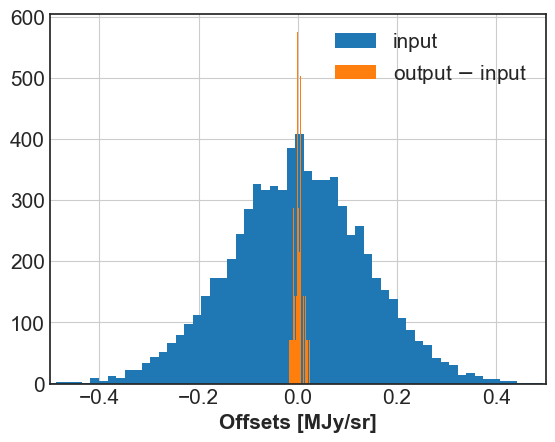

In [38]:
# Histogram of separations
import matplotlib.pyplot as plt
plt.hist(np.ravel(offin), bins=60,label='input')
doff = offout+offin
for d in doff:
    #d+= np.array(average)-ave
    d-= offsets0
plt.hist(np.ravel(doff), bins=60, label='output $-$ input')
print('mean ', np.mean(doff), ' dispersion ', np.std(doff))
plt.xlim(-0.5,0.5)
plt.grid()
plt.legend()
plt.xlabel('Offsets [MJy/sr]')
plt.show()

In [27]:
print(np.shape(offout))
print(n)
print(np.array(average))
print(ave)

(100, 72)
100
[0.6592492  0.6833627  0.67505205 0.71140206 0.6790085  0.72665703
 0.6233072  0.7194394  0.6795403  0.6619142  0.659293   0.6886052
 0.66605777 0.6794906  0.64634025 0.67589635 0.78777957 0.7541365
 0.6597481  0.6802769  0.6748594  0.71194863 0.678794   0.72691923
 0.6235354  0.7198583  0.67913043 0.6619962  0.65945977 0.6886893
 0.66597396 0.67892253 0.6461635  0.6760721  0.7882798  0.7557464
 0.6611218  0.6823017  0.6768832  0.71340525 0.6803199  0.7283138
 0.6248003  0.72112054 0.6813782  0.6637237  0.66428995 0.69019234
 0.6673657  0.6808529  0.6476793  0.67751145 0.79026556 0.75687844
 0.66063225 0.68258476 0.6766595  0.71349007 0.68054837 0.7284758
 0.62469304 0.72095287 0.6810148  0.6633436  0.66052675 0.69042027
 0.66715753 0.68029344 0.64753836 0.6778224  0.7892685  0.75608665]
0.6883725


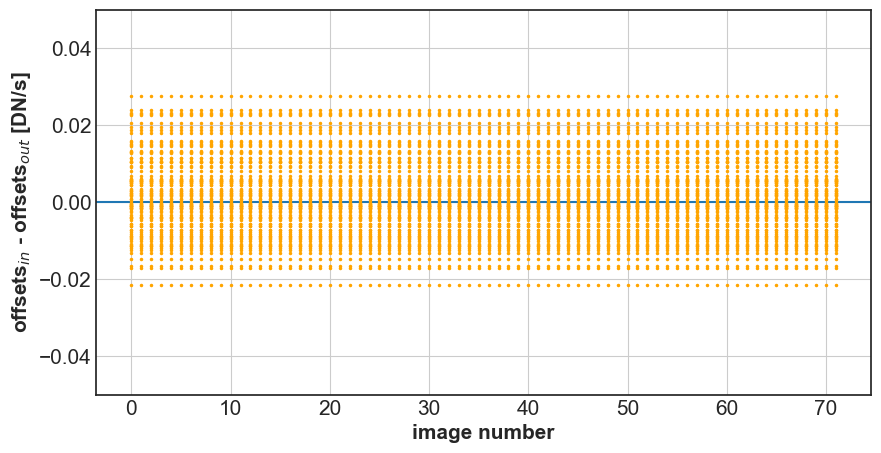

In [37]:
fig,ax = plt.subplots(figsize=(10,5))
plt.axhline(0)
plt.ylim(-0.05,0.05)
#plt.plot(np.nanmedian(doffsets,0)+np.array(average)-ave,color='orange',label='simulations')
for i in range(n):
    #plt.plot(offin[i,:]+offout[i,:]+np.array(average)-ave,'.',color='orange',ms=3)
    plt.plot(offin[i,:]+offout[i,:]-offsets0,'.',color='orange',ms=3)
#plt.plot(-np.array(average)+ave,color='blue',label='image medians with no offsets')
#plt.legend()
plt.xlabel('image number')
plt.ylabel('offsets$_{in}$ - offsets$_{out}$ [DN/s]')
plt.grid()
plt.show()

# Equations for pixmatch

$L = \Sigma_{n=1,N}\Sigma_{m\ne n} \Sigma_{k \in (I_n\cap I_m)} \frac{(I_n(k) + \epsilon_n - I_m(k) -\epsilon_m)^2}{\sigma^2_n(k) + \sigma^2_m(k)}$

For sake of simplicity, let's take away the sum on the overlap:

$L = \Sigma_{n=1,N}\Sigma_{m\ne n} \frac{(I_n + \epsilon_n - I_m -\epsilon_m)^2}{\sigma^2_n + \sigma^2_m}$

Now, let's differentiate with respect to $\epsilon_i$ with $i = 1, N$:

$\partial L/\partial \epsilon_i = 0$  with $i = 1, N$

$\Sigma_{n=1,N}\Sigma_{m\ne n} 2 \frac{(I_n + \epsilon_n - I_m -\epsilon_m)}{\sigma^2_n + \sigma^2_m} \frac{\partial(I_n + \epsilon_n - I_m -\epsilon_m)}{\partial \epsilon_i} = 0$

since $I_n$ and $I_m$ are constants, this is equivalent to:

$\Sigma_{n=1,N}\Sigma_{m\ne n} \frac{(I_n + \epsilon_n - I_m -\epsilon_m)}{\sigma^2_n + \sigma^2_m} \frac{\partial(\epsilon_n-\epsilon_m)}{\partial \epsilon_i} = 0$

Now, $\frac{\partial(\epsilon_n)}{\partial \epsilon_i}$ is 1 iff $n=i$, otherwise it's 0.

This means that the sum becomes:

$\Sigma_{m\ne i} \frac{(I_i + \epsilon_i - I_m -\epsilon_m)}{\sigma^2_i + \sigma^2_m} = 0$ with $i=1,N$

which can be written as:

$\epsilon_i \Sigma_{m\ne i} \frac{1}{\sigma^2_i + \sigma^2_m} + \Sigma_{m\ne i} \epsilon_m \frac{-1}{\sigma^2_i + \sigma^2_m}  = \Sigma_{m\ne i} \frac{I_m-I_n}{\sigma^2_i + \sigma^2_m}$

So, if we write:

$A_{nn} = \Sigma_{m\ne n} \frac{1}{\sigma^2_n + \sigma^2_m}$

$A_{nm} = \frac{-1}{\sigma^2_n + \sigma^2_m}$

$B = \Sigma_{m\ne n} \frac{I_m-I_n}{\sigma^2_i + \sigma^2_m}$

We can write the system of linear equations as:

$A \epsilon = B $